## Import Libraries

In [1]:
from fastai.vision import *
from fastai import *
from fastai.data_block import *

from pathlib import Path

from unet import VolumetricUnet, dice_loss, dice_score, predict, plot_predictions, eval_preds

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import FloatTensor as FT

## Choose GPU

In [2]:
torch.cuda.set_device(5)

In [3]:
!ls /data/public/Segmentation_Dataset/CT_Dataset/train

brain_atlas  raw_images      ventricle_atlas
brain_masks  skull_stripped  ventricle_masks


## Load and Prepare Data

In [4]:
data_path = Path("/data/public/Segmentation_Dataset/CT_Dataset")
trn_img = sorted(list(Path(data_path/"train/skull_stripped").iterdir()))
trn_mask = sorted(list(Path(data_path/"train/ventricle_masks").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/skull_stripped").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/ventricle_masks").iterdir()))

In [5]:
print(f"Size of Train Dataset: {len(trn_img)} Images")
print(f"Size of Validation Dataset: {len(valid_img)} Images")

Size of Train Dataset: 107 Images
Size of Validation Dataset: 26 Images


In [6]:
class CT_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)
    
train_ds = CT_3D_Dataset(trn_img, trn_mask)
valid_ds = CT_3D_Dataset(valid_img, valid_mask)   

data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=3)

In [7]:
unet = VolumetricUnet(in_channel=1, out_channel=4, num_classes=1)

In [8]:
learner = Learner(data=data, model=unet)

In [9]:
learner.loss_func = dice_loss
learner.metrics = [dice_score]

In [10]:
learner.to_fp16();

In [16]:
# learner.lr_find()

In [17]:
# learner.recorder.plot()

In [13]:
# learner.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,dice_score
1,0.986844,0.996593,0.003407
2,0.902039,nan,0.000000
3,0.722767,0.537502,0.463188
4,0.625311,0.524429,0.477423
5,0.545595,0.403794,0.599549


In [14]:
learner.save('DL_Ventricles_NoTL_CT_5_epochs_5e-2')

In [15]:
learner.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,dice_score
1,0.470876,0.482309,0.519823
2,0.519777,0.568486,0.433635
3,0.522290,0.534466,0.466721
4,0.536491,0.466210,0.535402
5,0.539532,0.549586,0.450787


In [16]:
learner.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,dice_score
1,0.487845,0.415127,0.586597
2,0.484722,0.487354,0.513559
3,0.484972,0.511109,0.488515
4,0.463170,0.324362,0.677441
5,0.427281,0.314504,0.686851


In [17]:
learner.save('DL_Ventricles_NoTL_CT_15_epochs_5e-2')

In [20]:
learner.load('DL_Ventricles_NoTL_CT_15_epochs_5e-2');

In [21]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


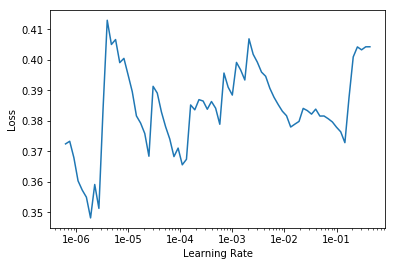

In [22]:
learner.recorder.plot()

In [23]:
learner.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,dice_score
1,0.377174,0.310011,0.691416
2,0.382748,0.309562,0.691945
3,0.353036,0.307141,0.694332
4,0.364753,0.300599,0.700686
5,0.372473,0.300720,0.700836


In [24]:
learner.save('DL_Ventricles_NoTL_CT_15_epochs_5e-2_5_epochs_5e-3')

In [12]:
learner.load('DL_Ventricles_NoTL_CT_15_epochs_5e-2_5_epochs_5e-3');

In [13]:
images, preds, masks = predict(learner, data)

In [14]:
IMG_NUM = 0
image = images[IMG_NUM]
pred = preds[IMG_NUM]
mask = masks[IMG_NUM]

/usr/local/share/anaconda3/envs/fastai/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


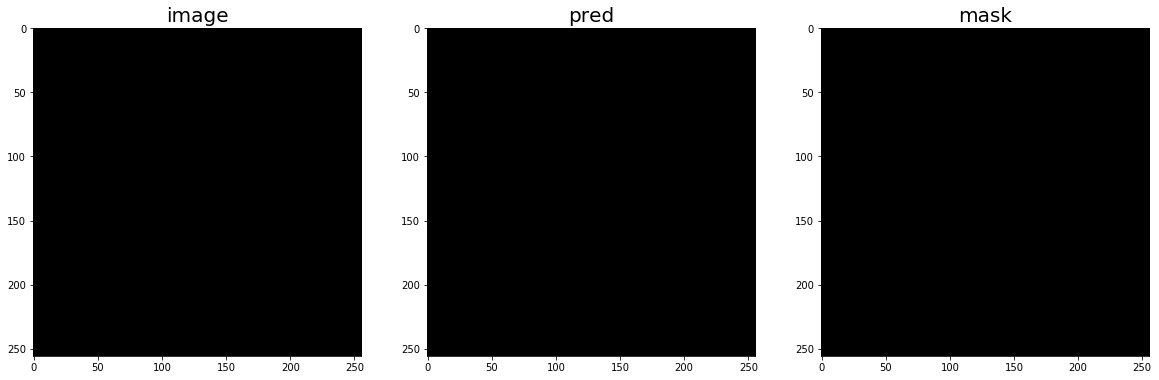

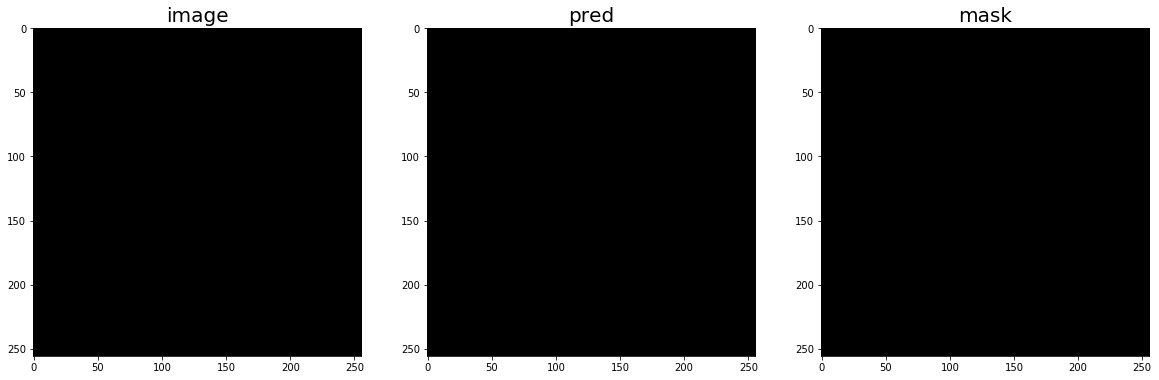

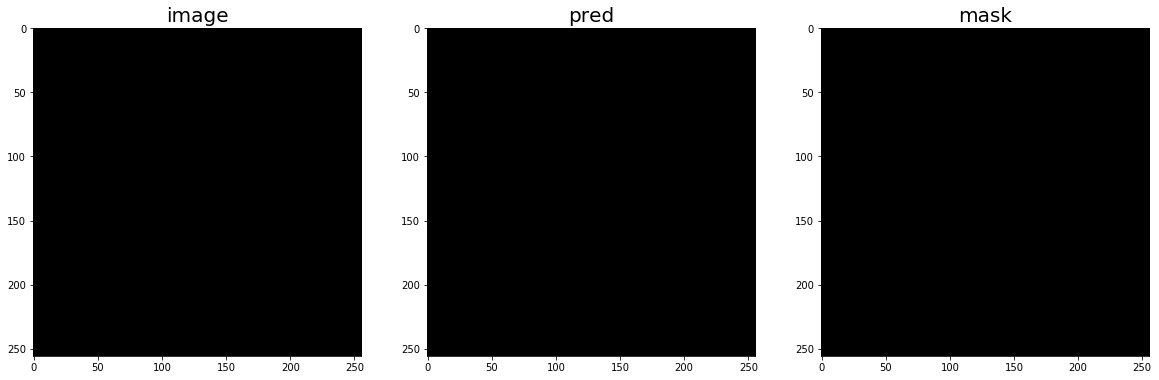

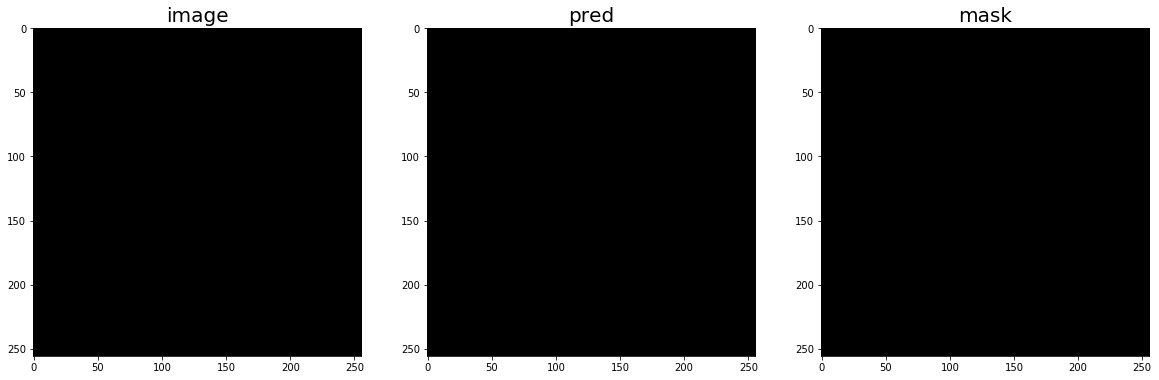

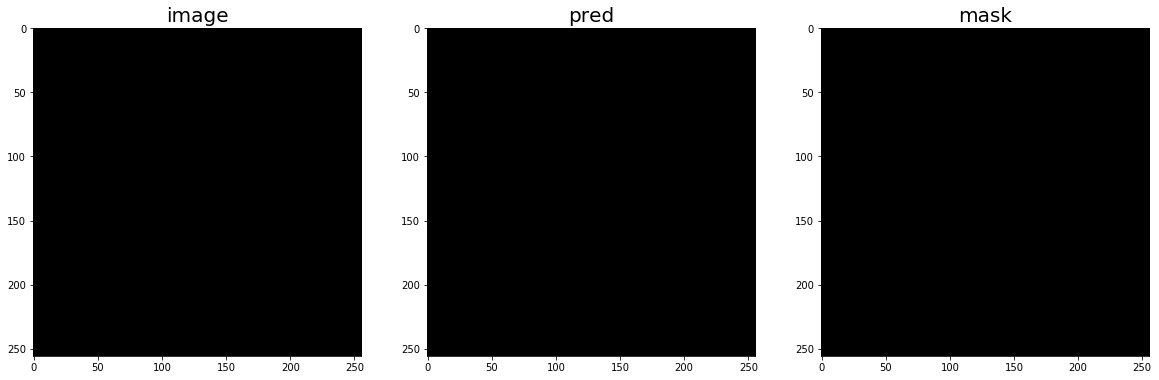

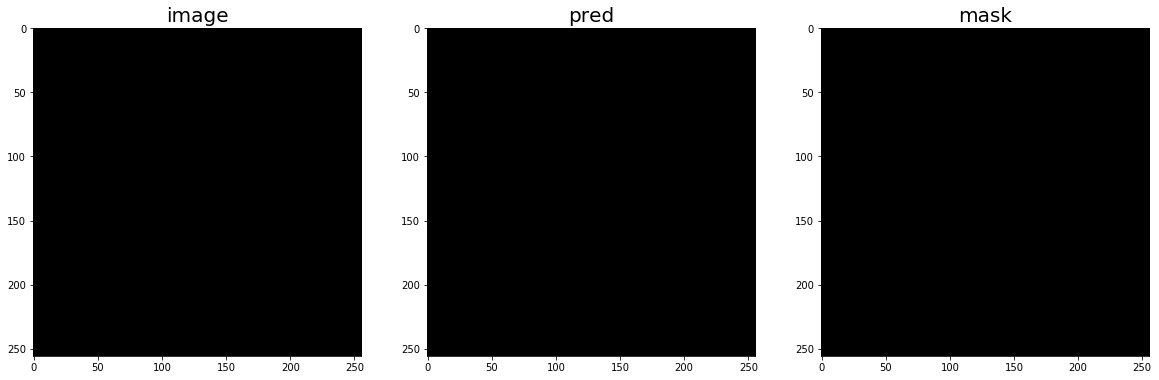

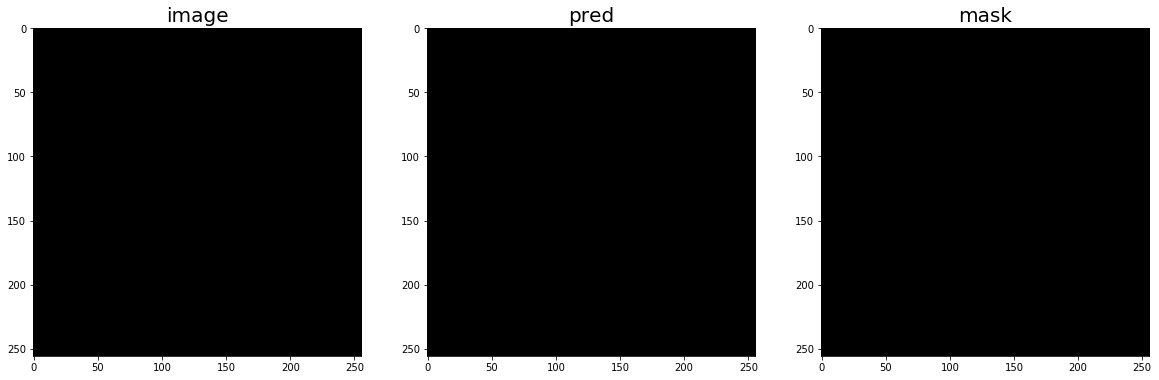

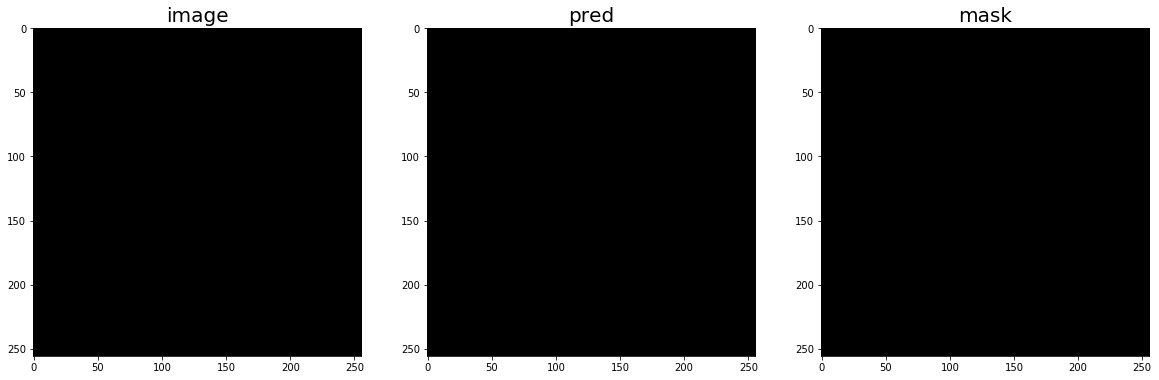

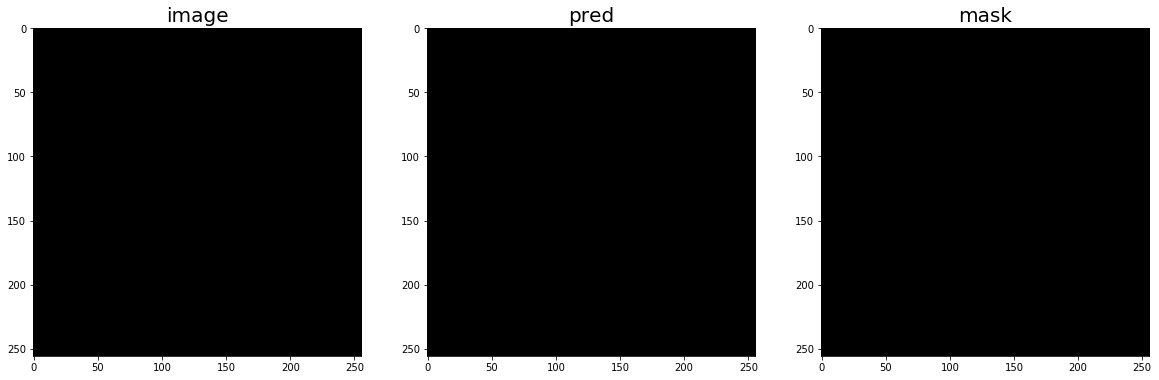

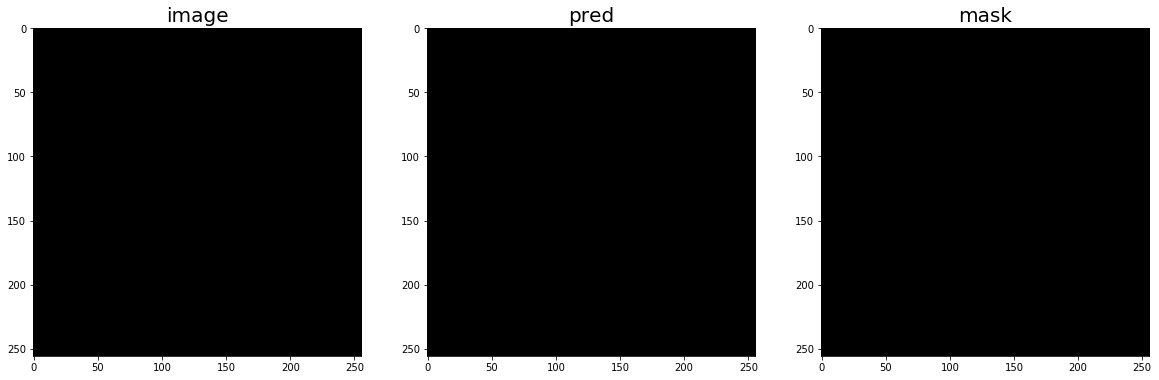

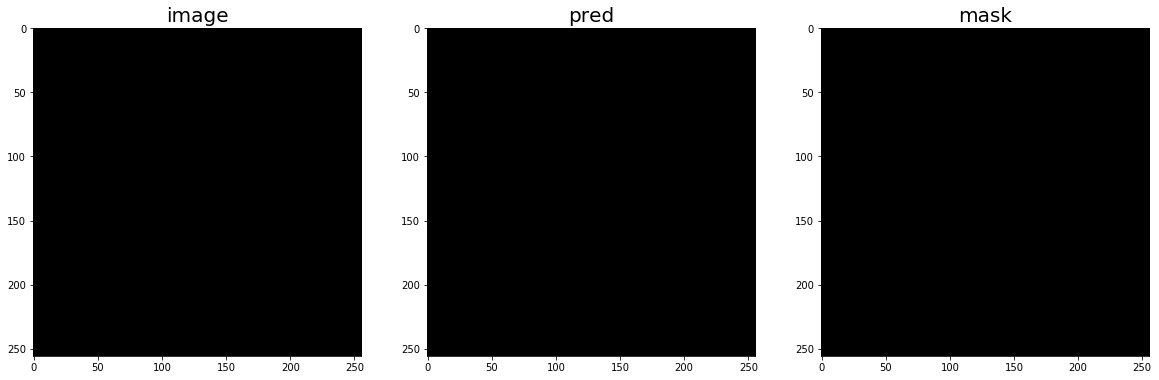

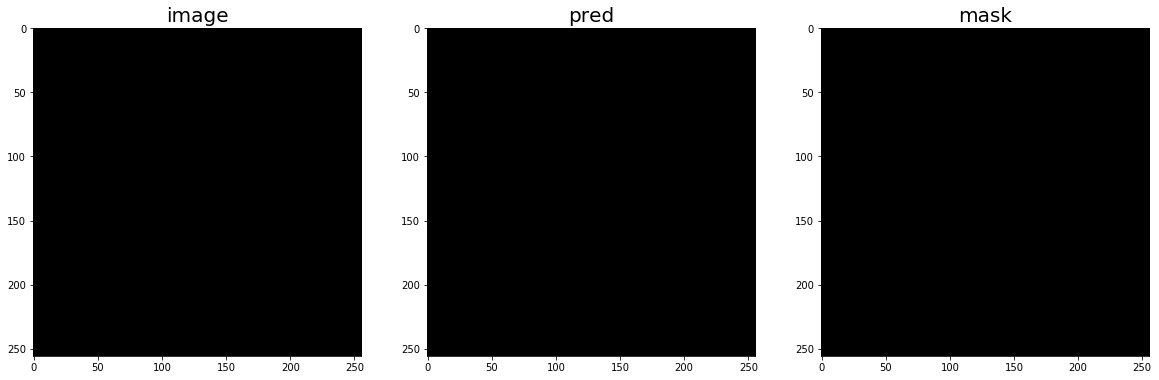

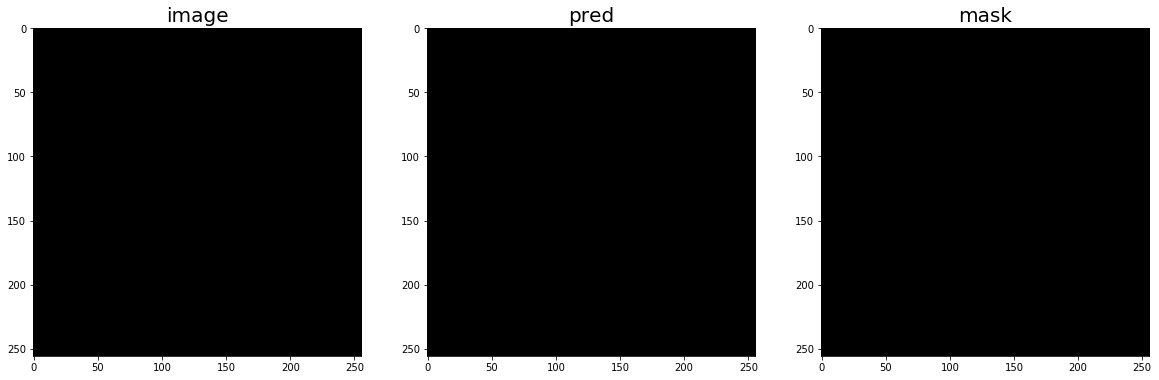

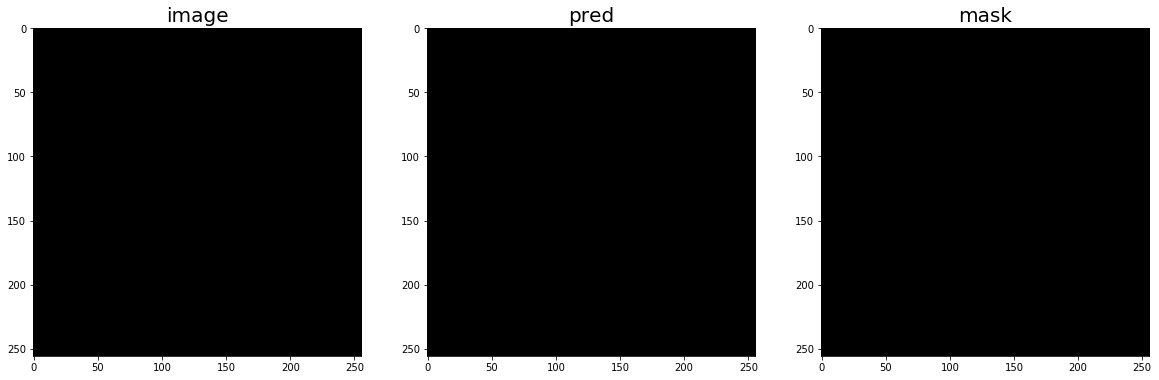

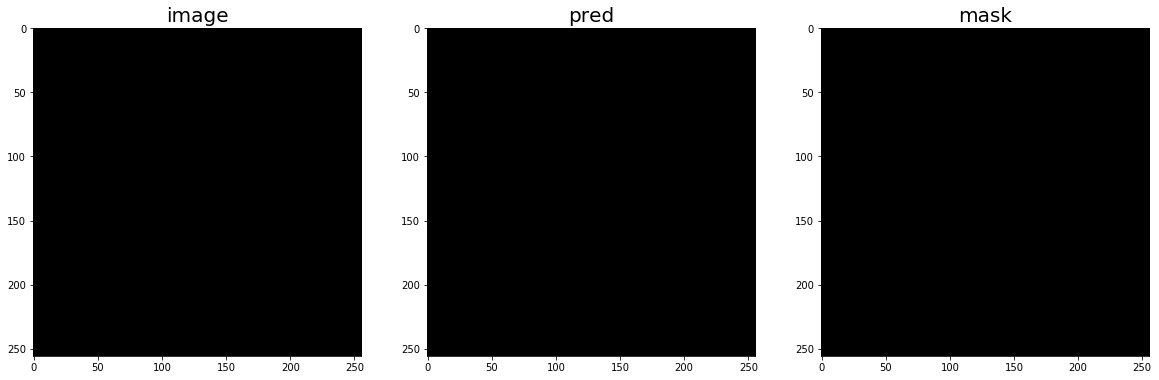

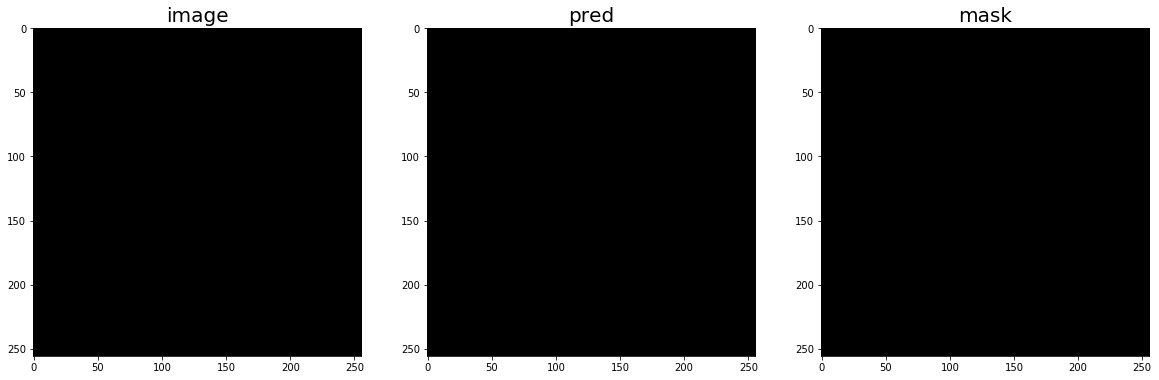

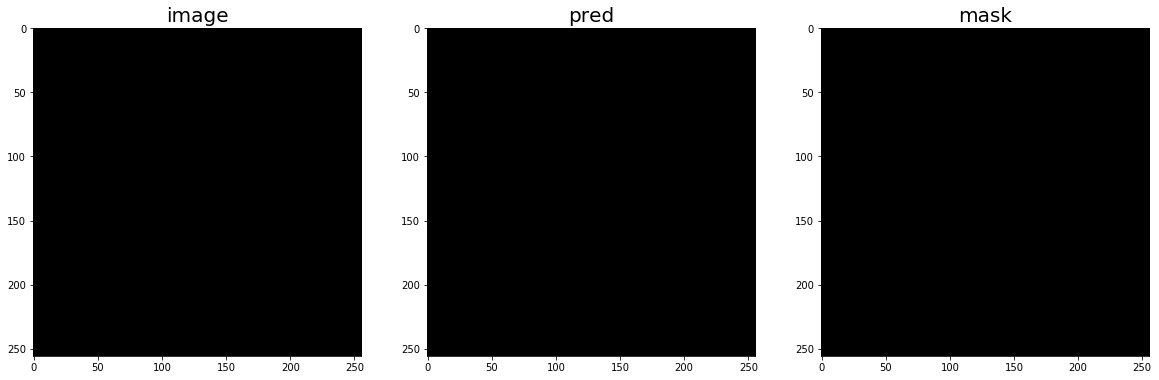

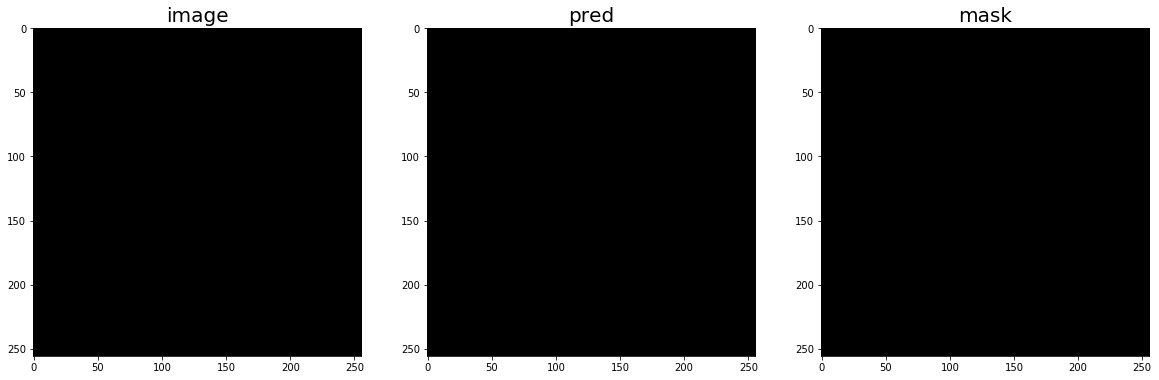

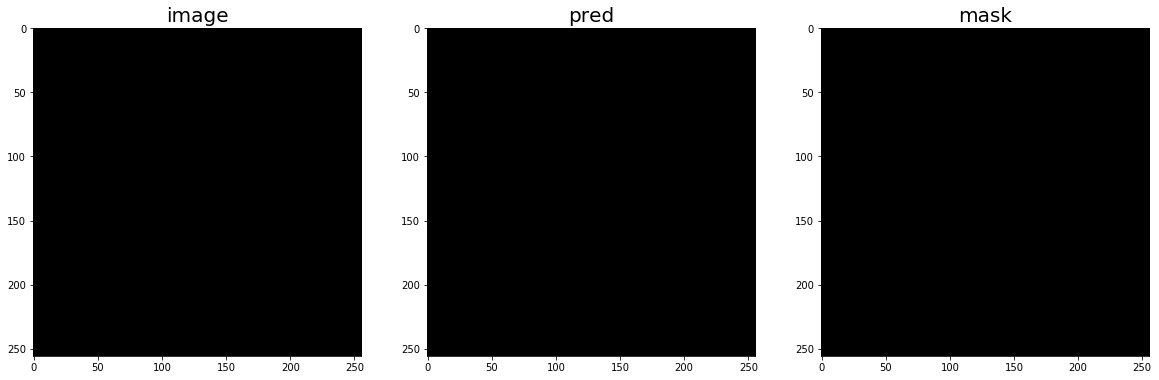

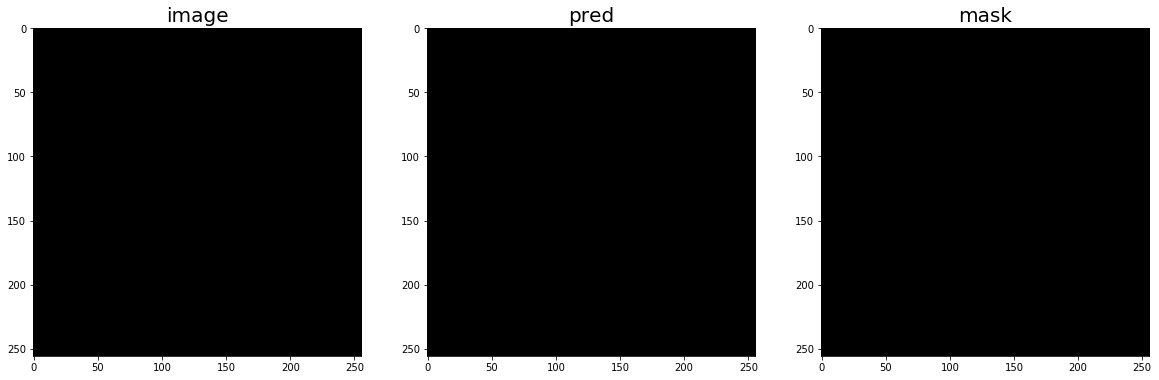

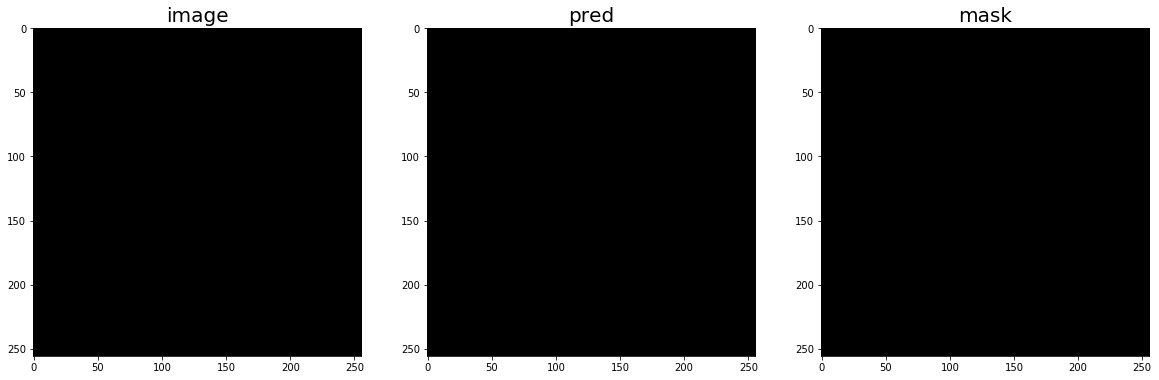

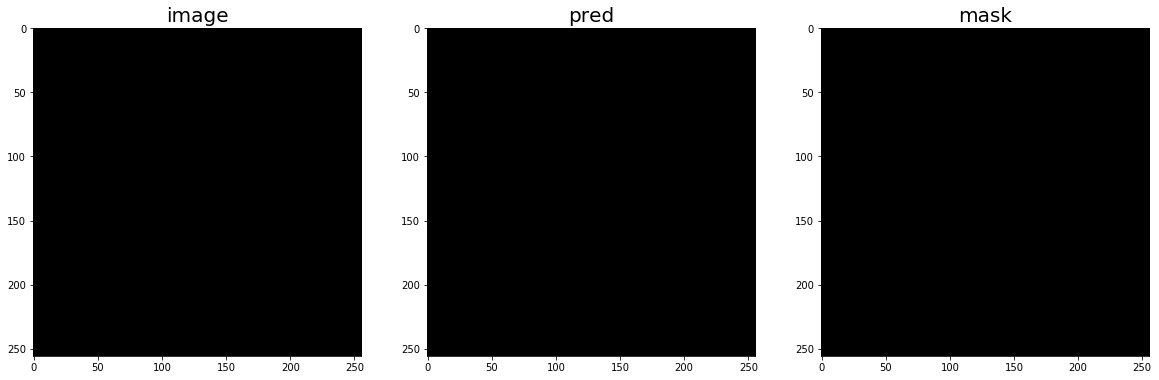

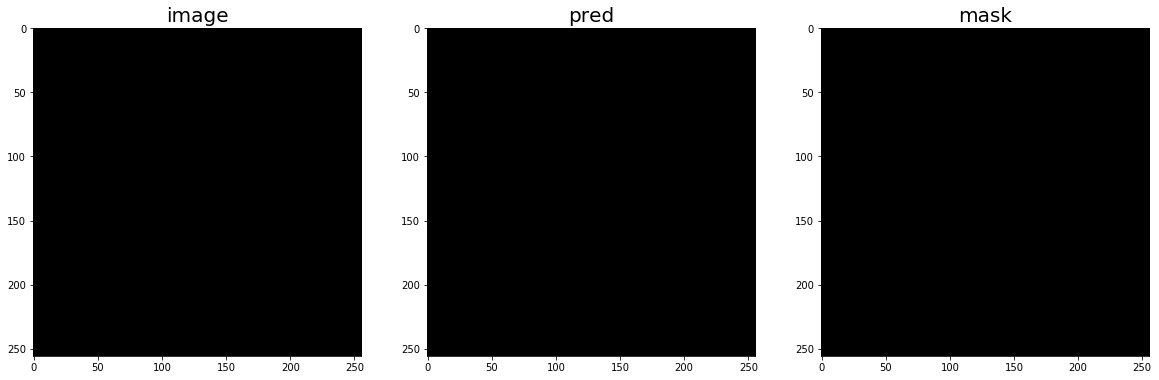

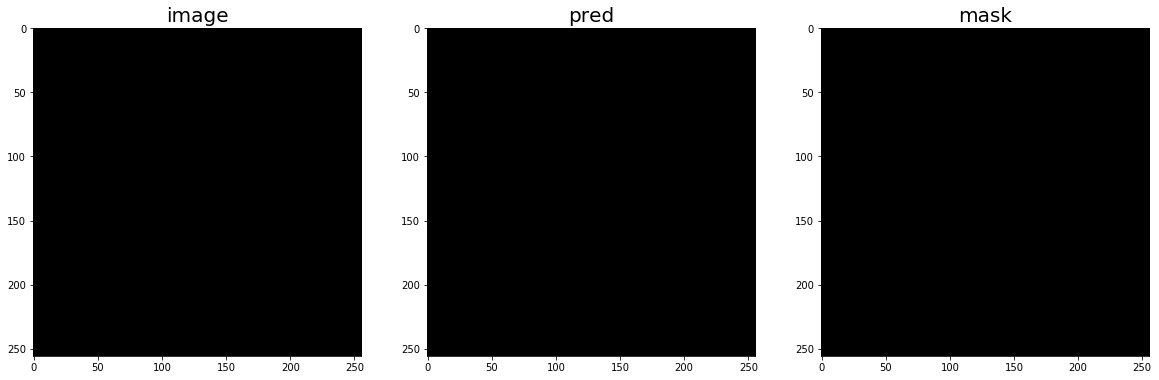

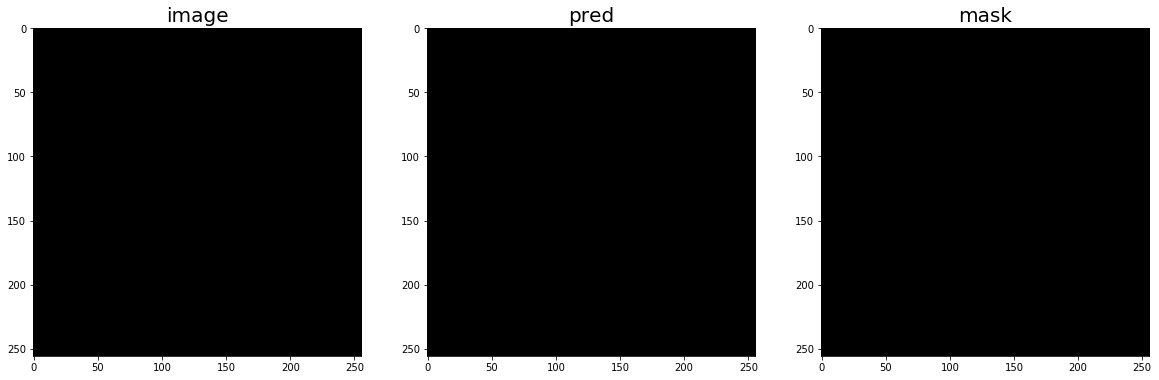

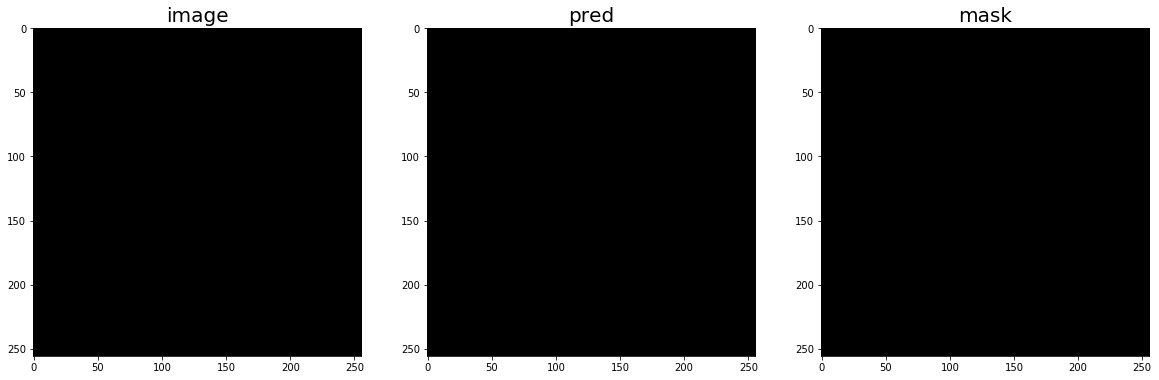

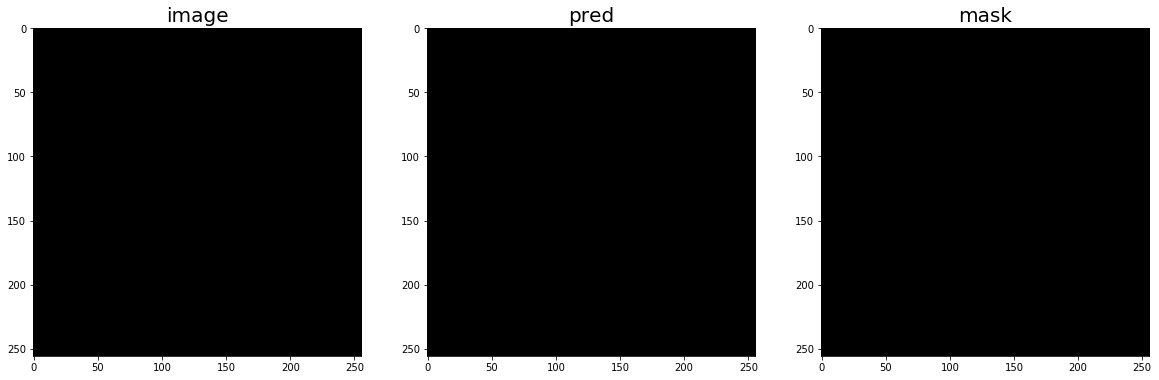

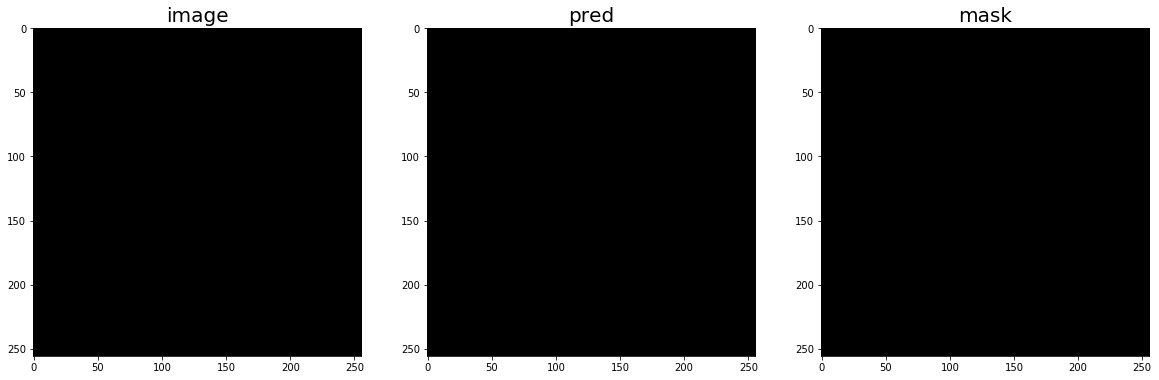

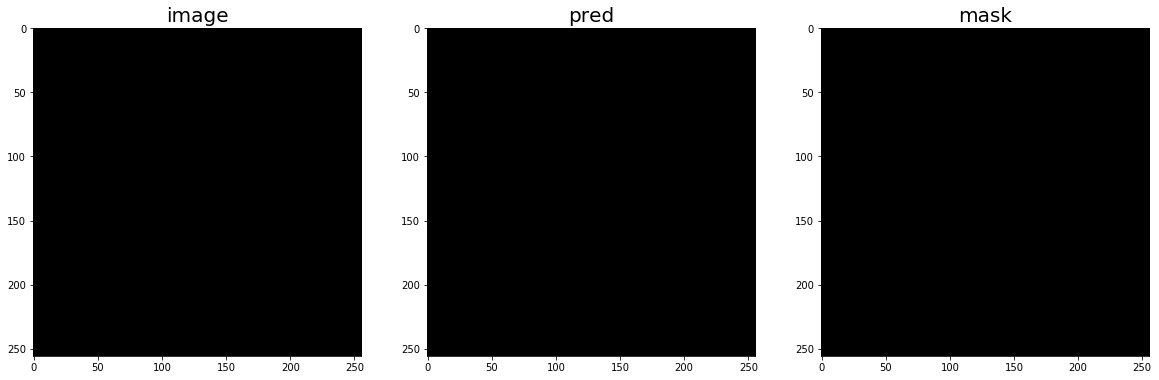

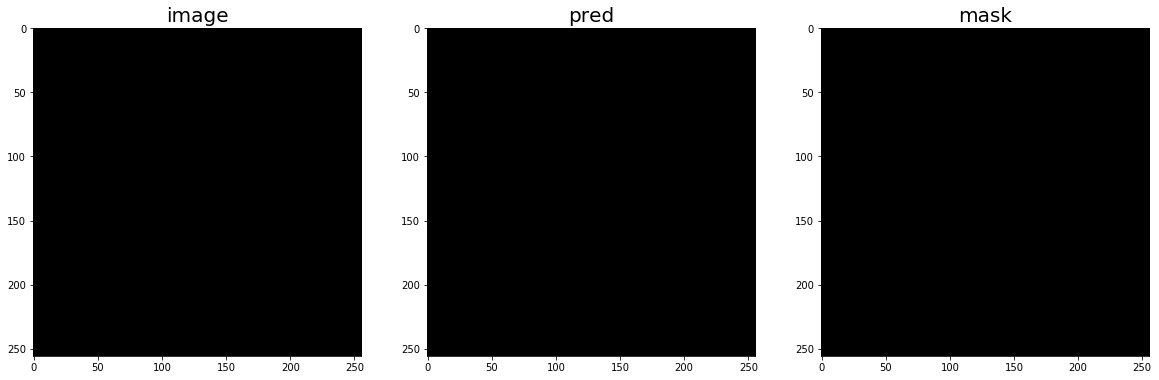

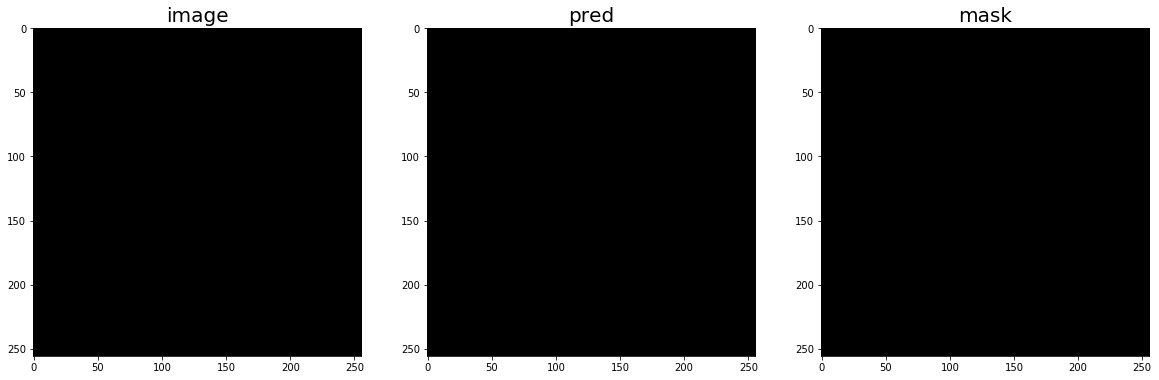

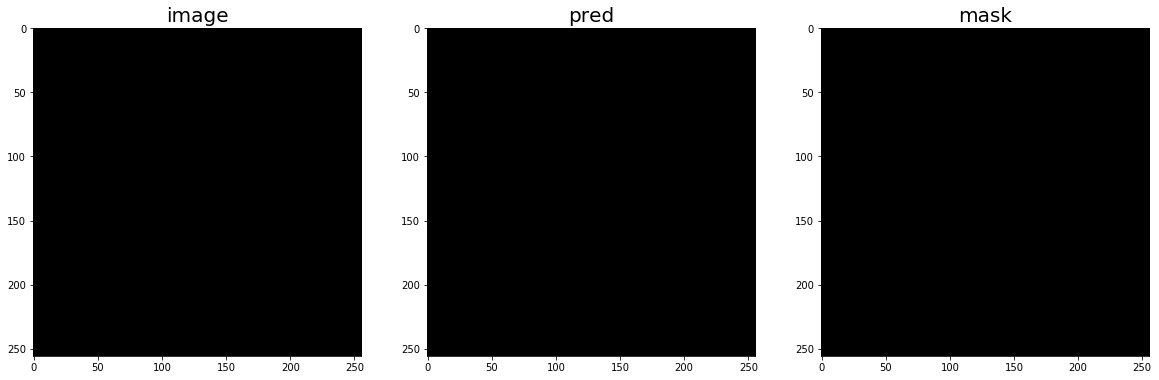

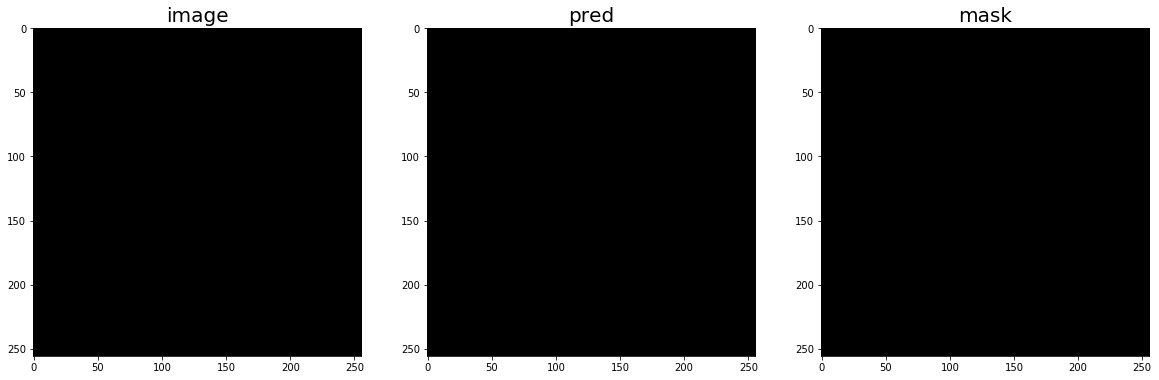

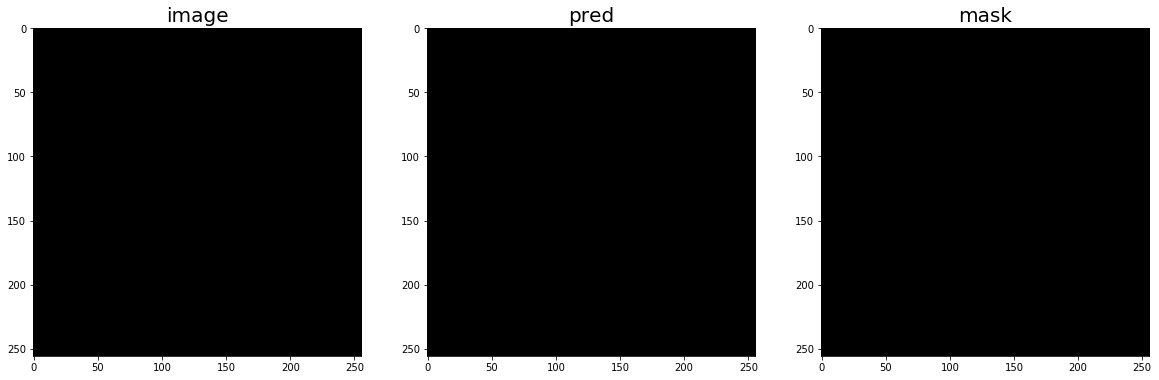

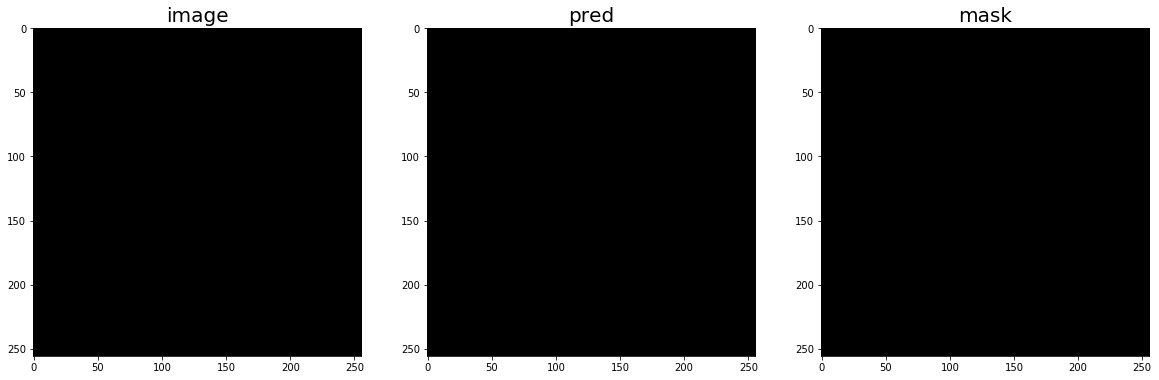

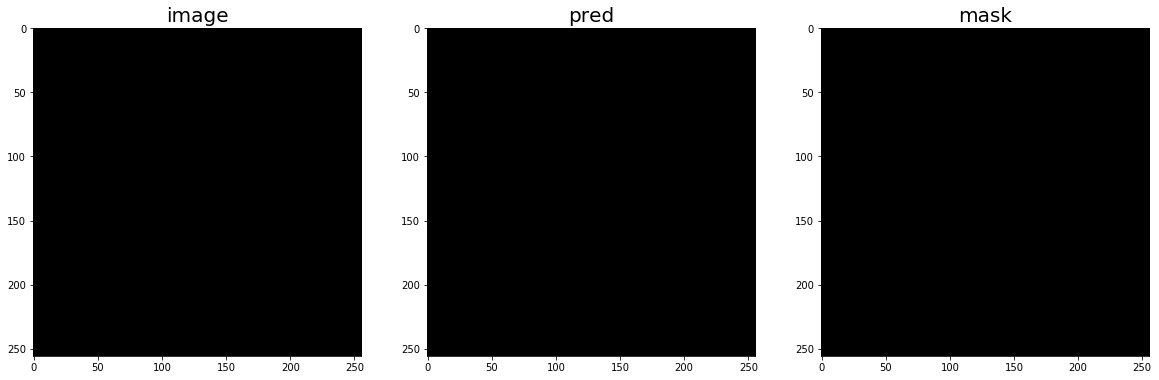

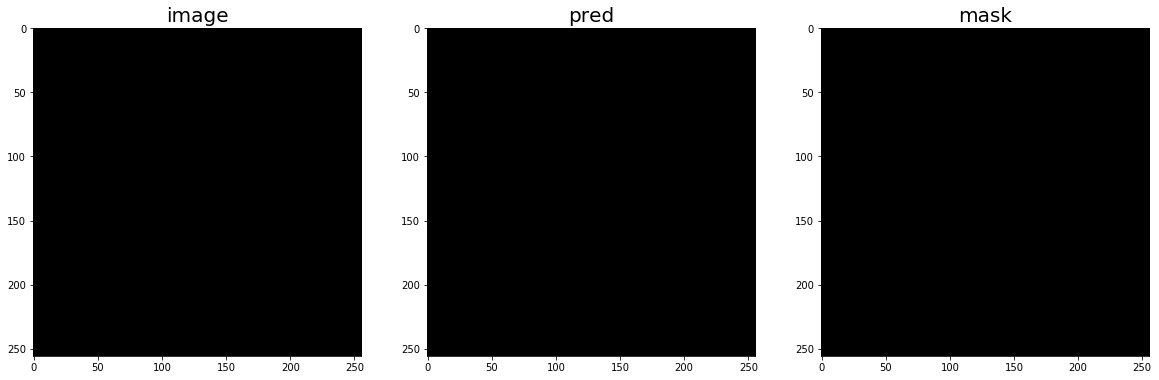

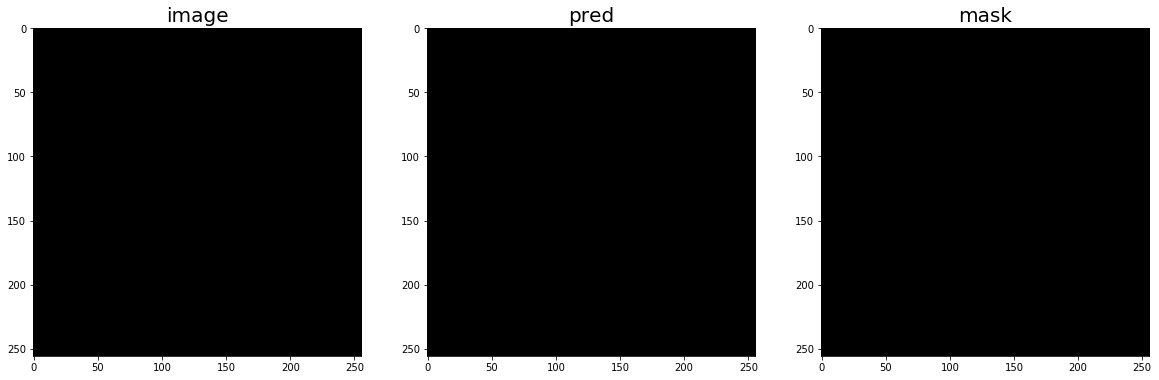

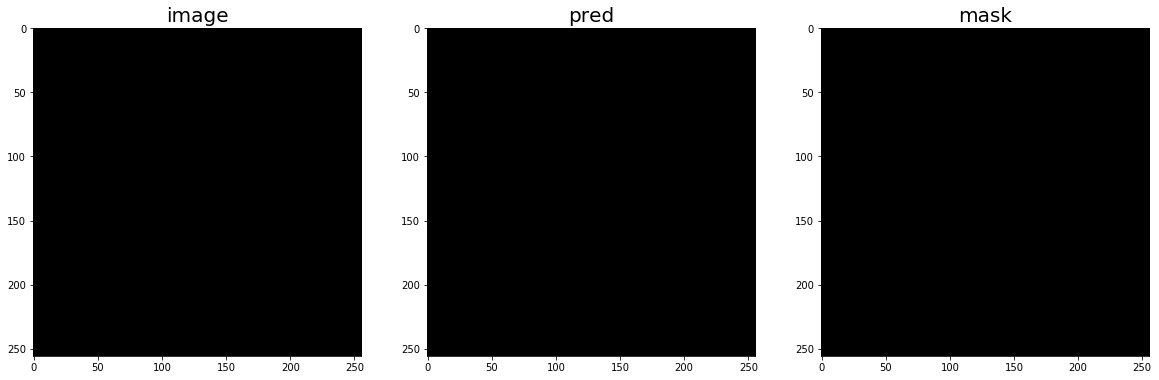

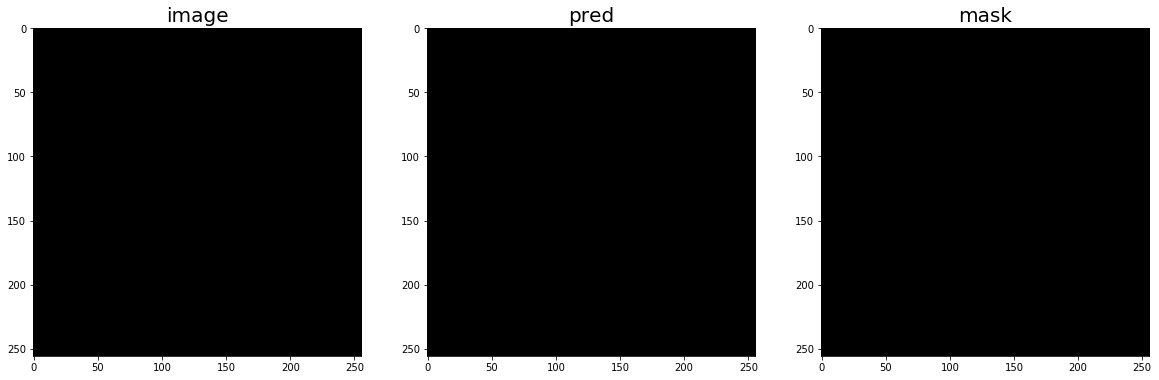

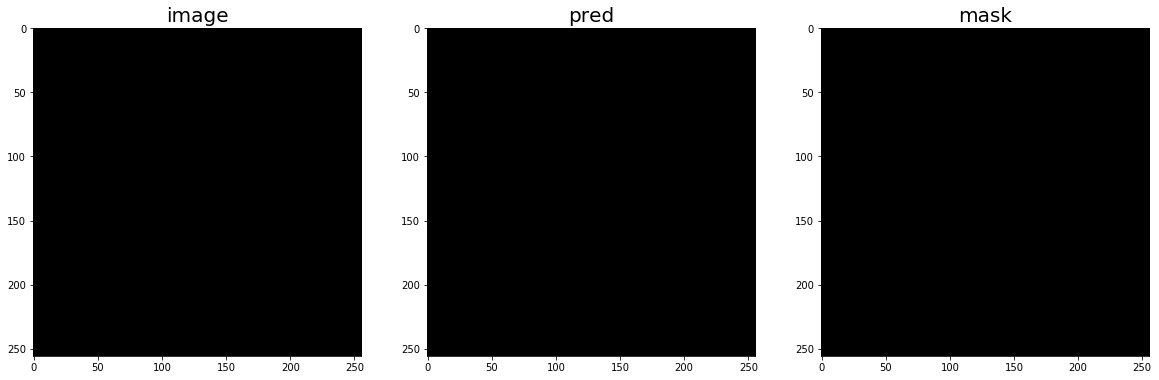

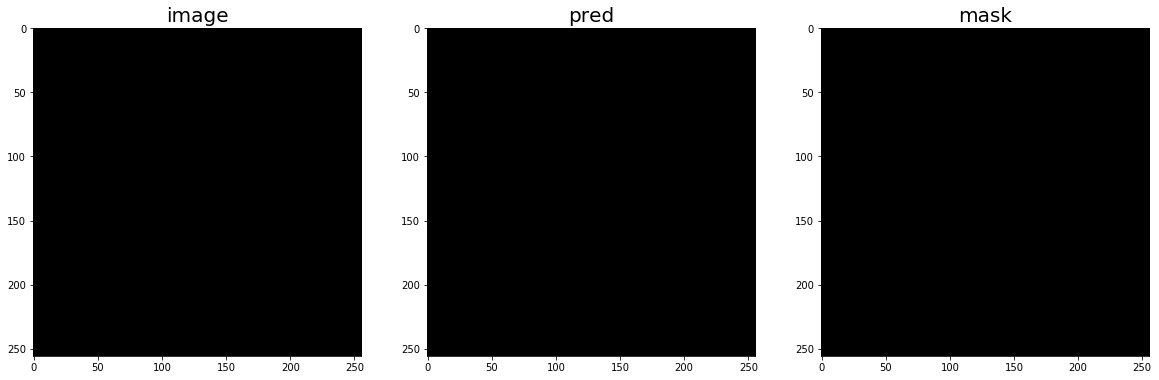

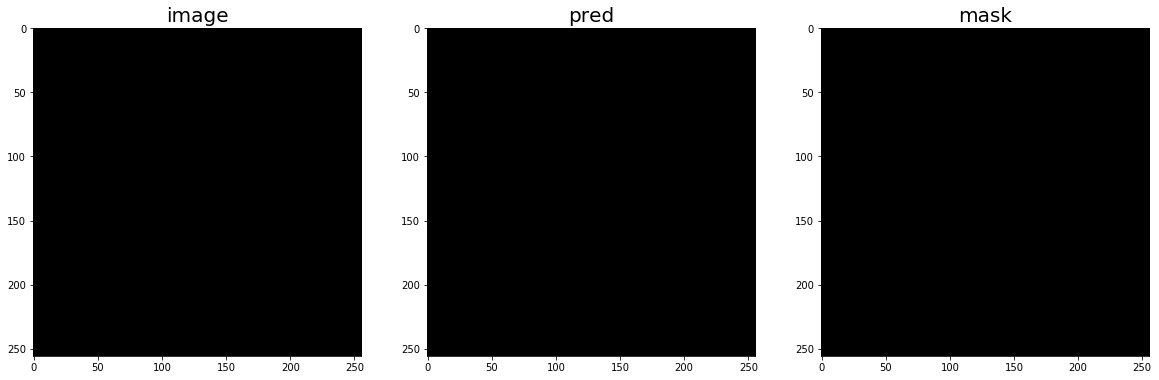

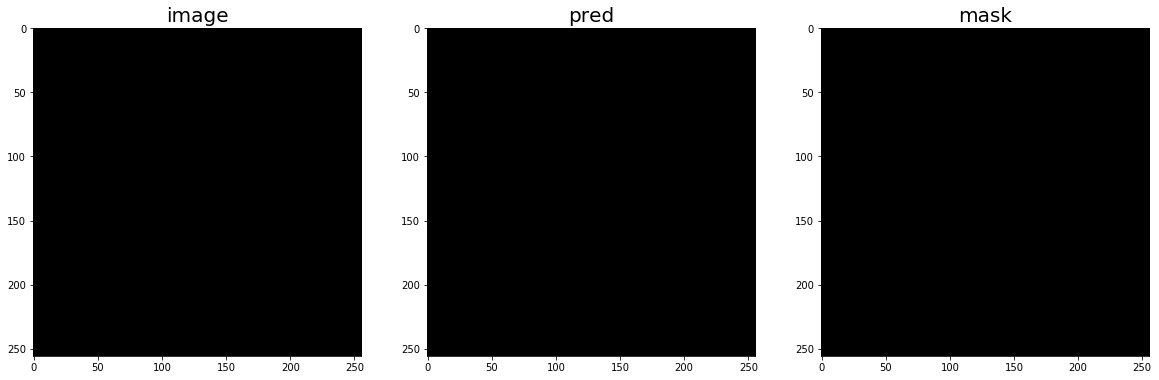

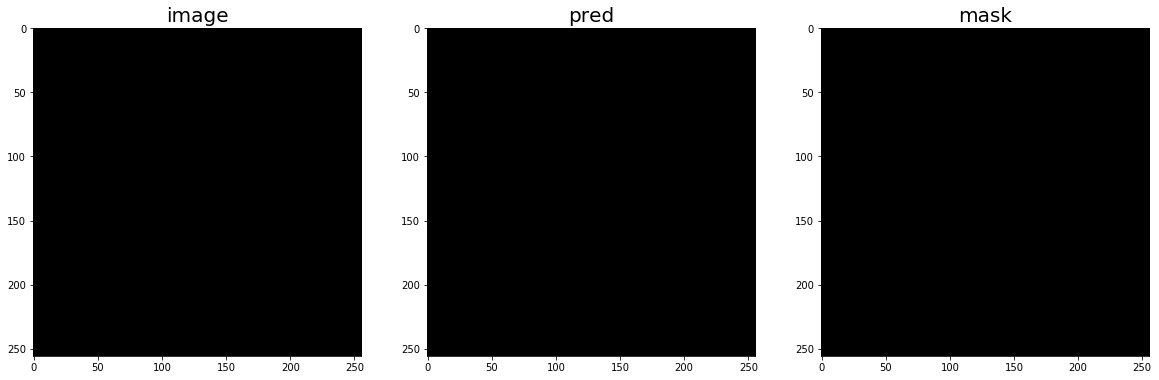

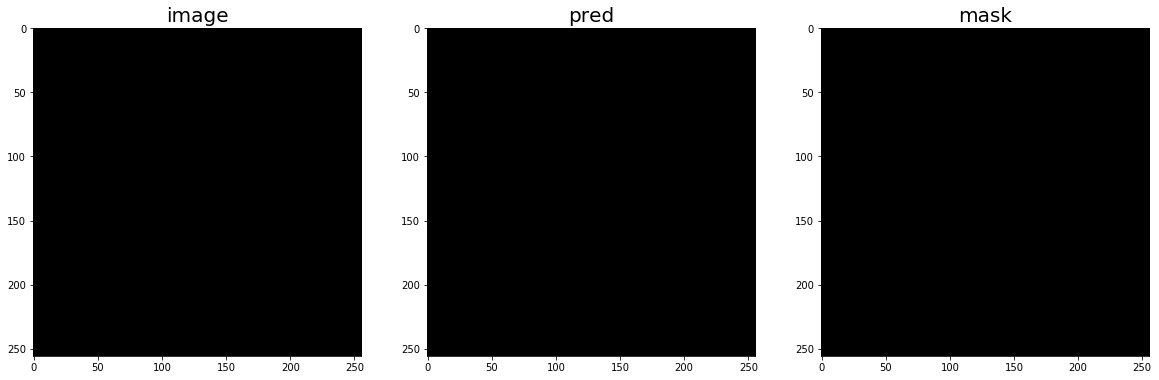

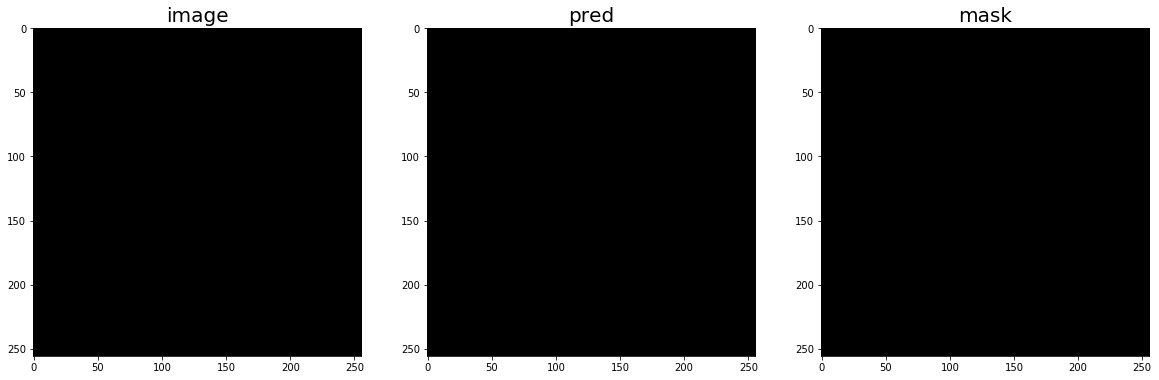

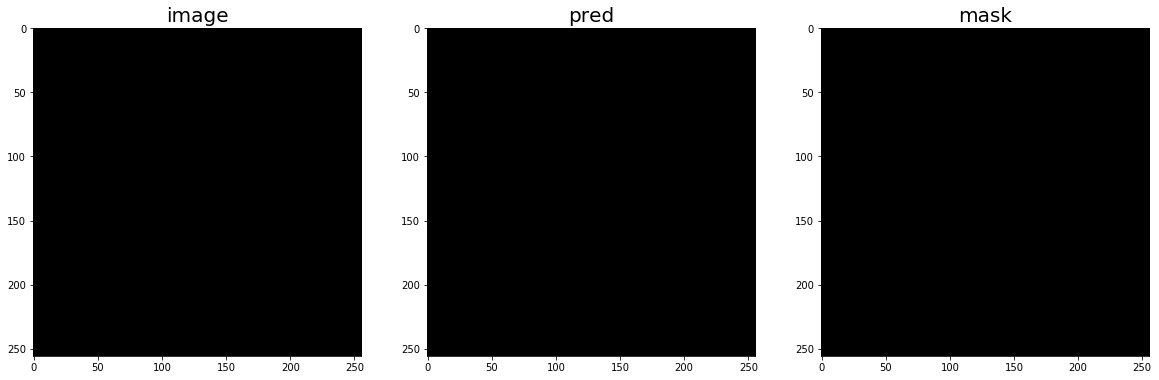

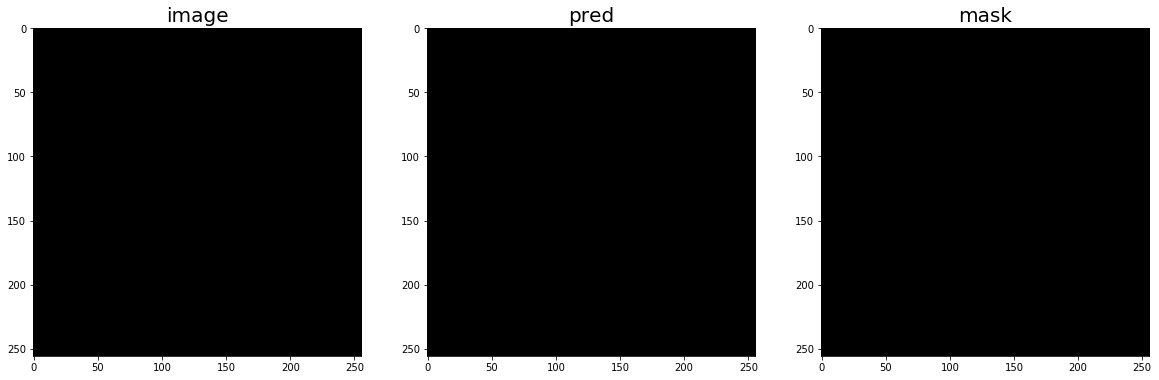

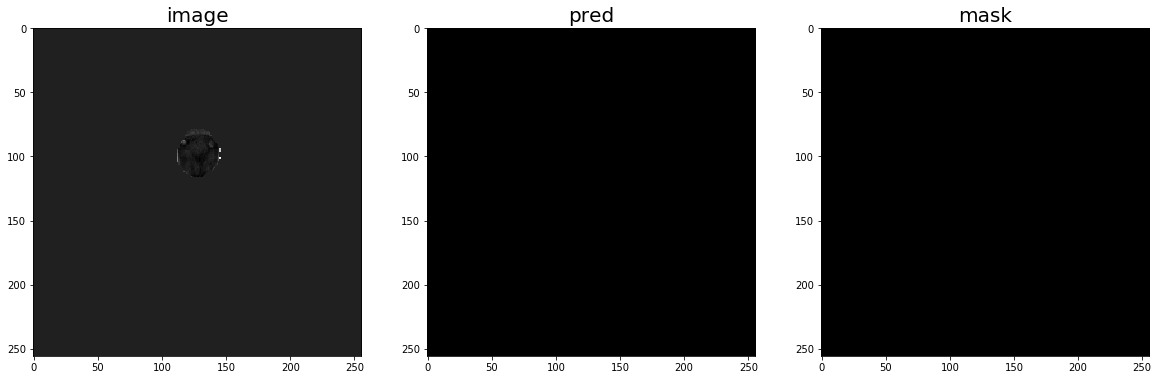

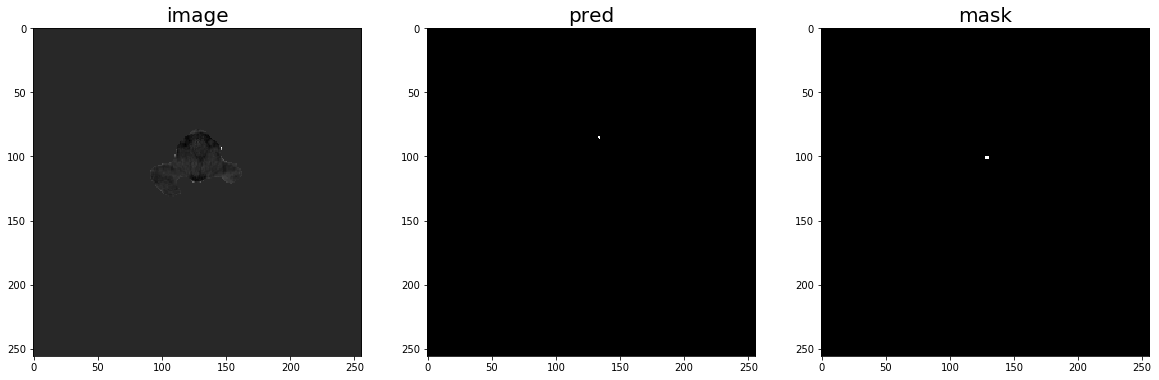

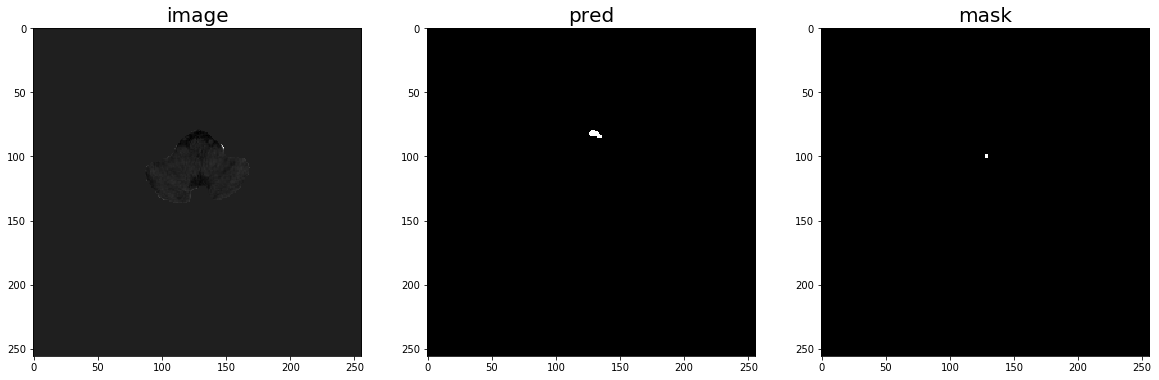

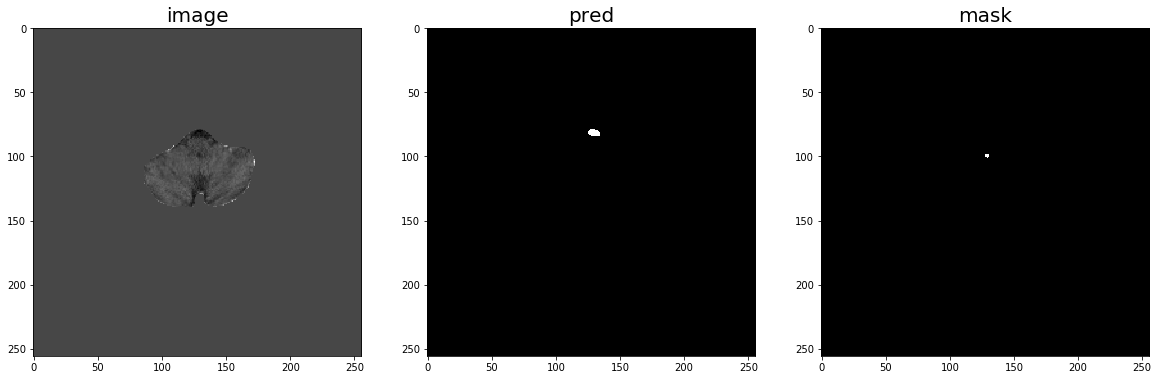

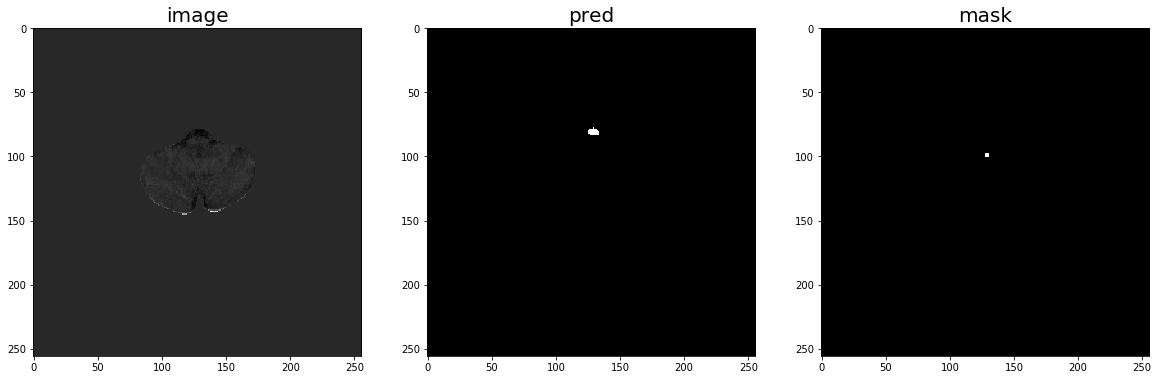

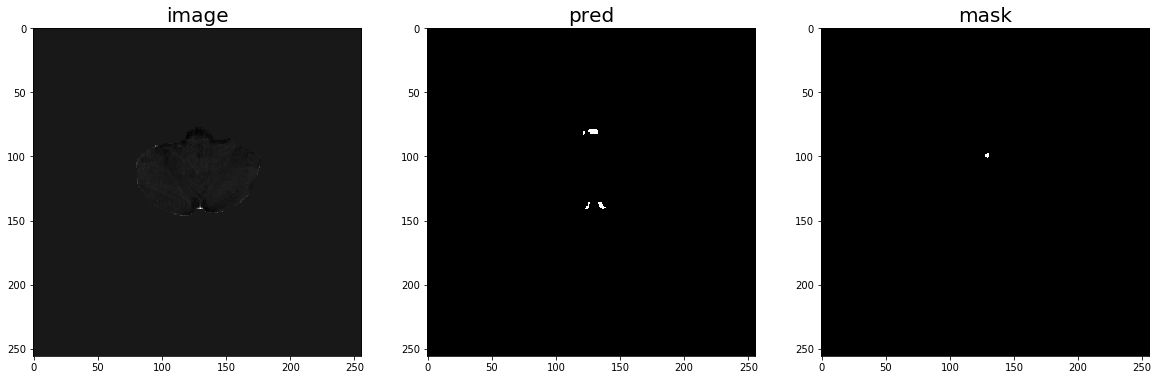

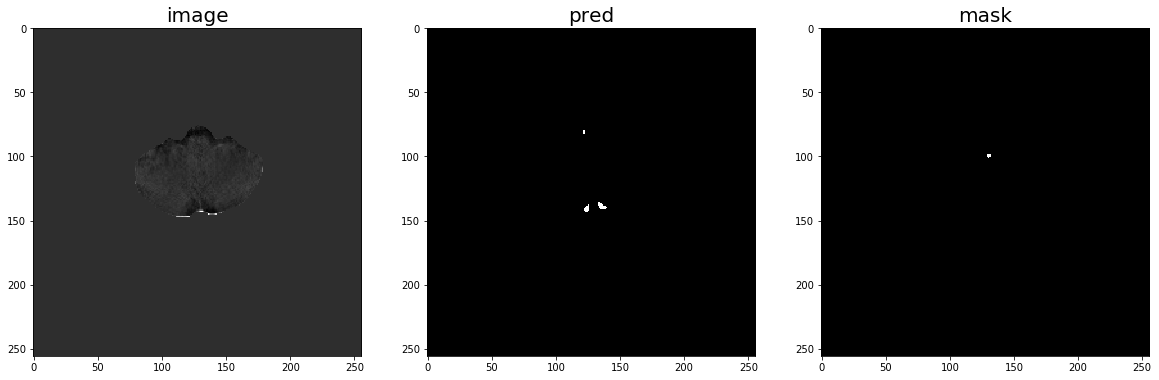

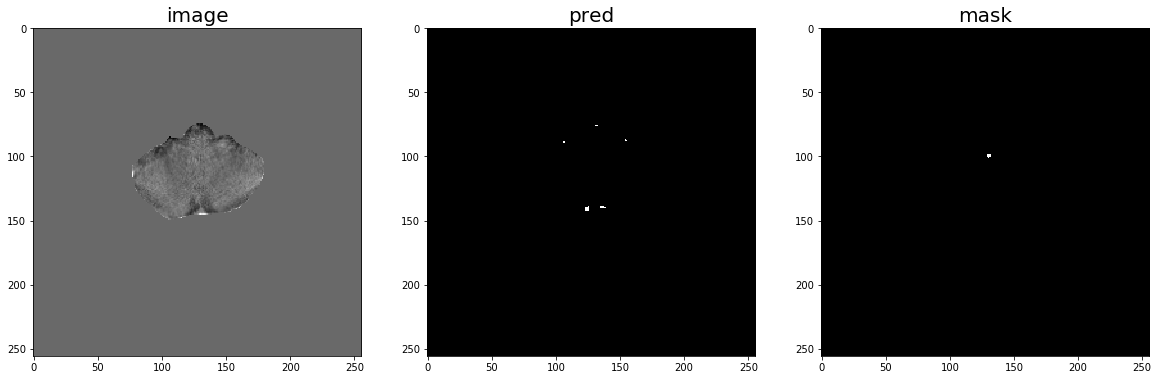

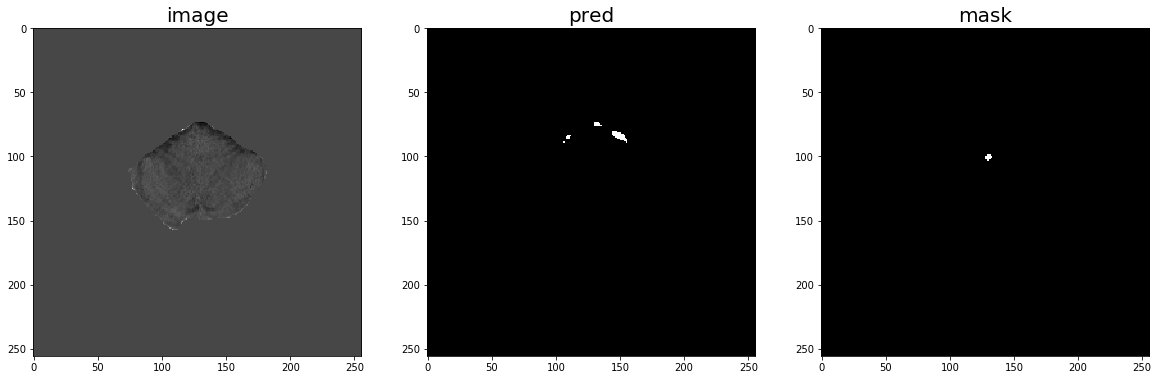

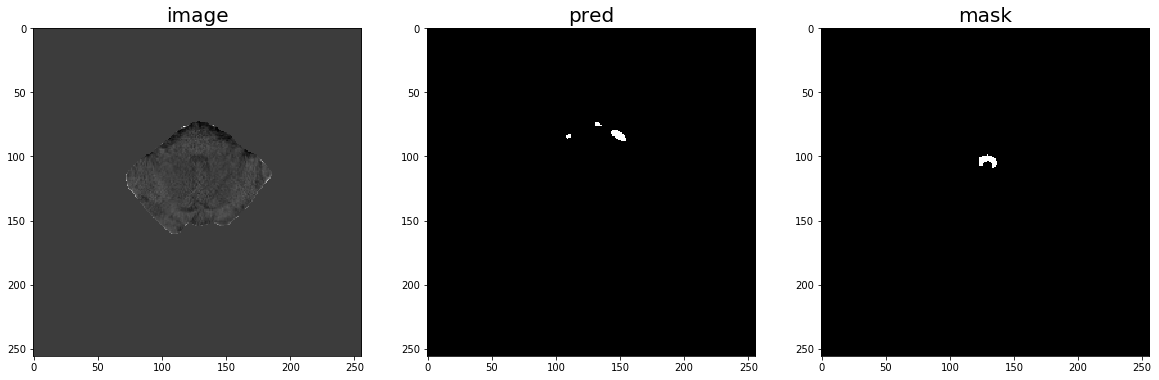

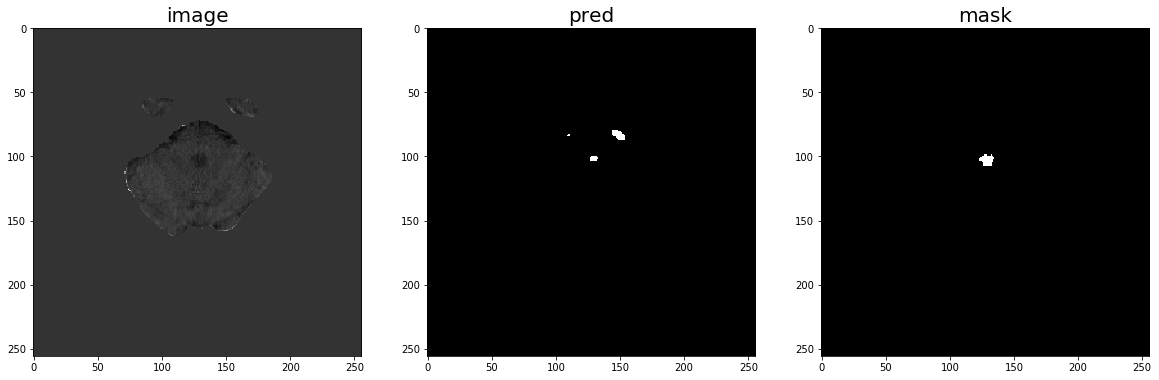

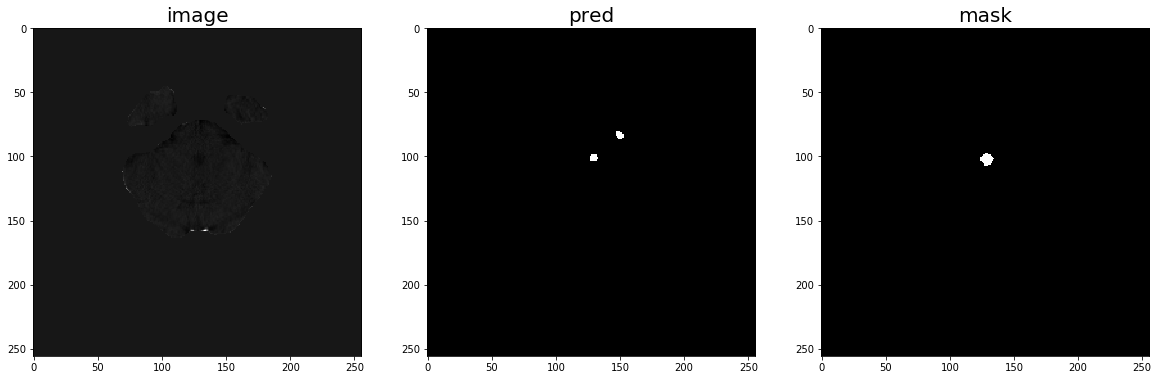

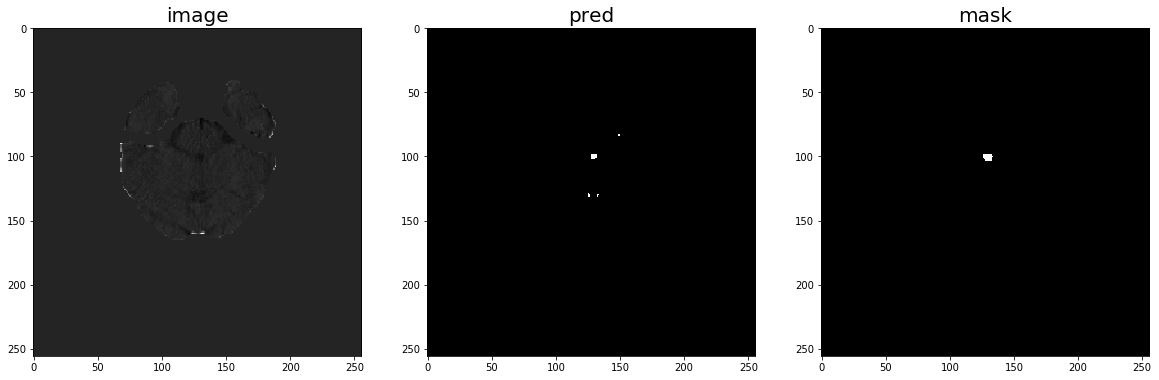

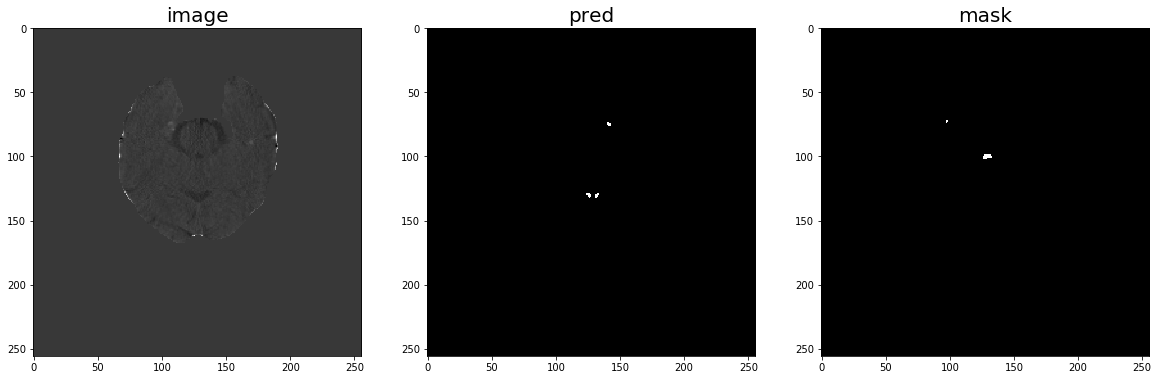

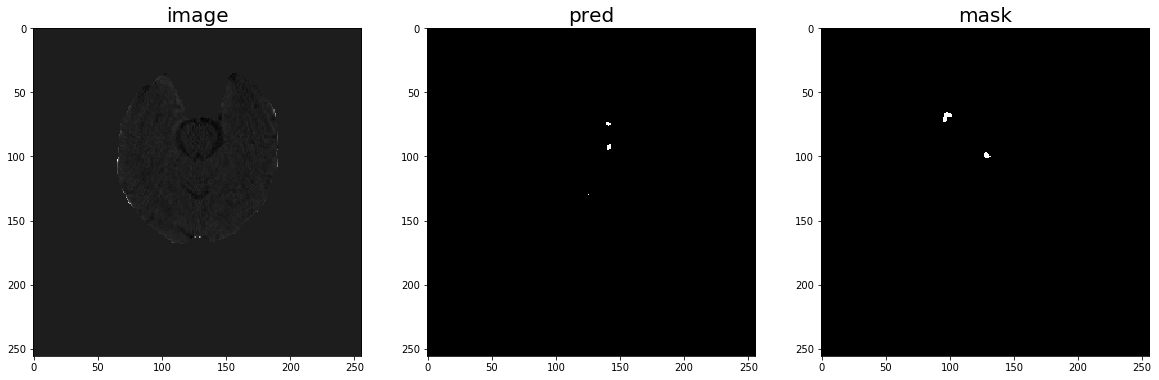

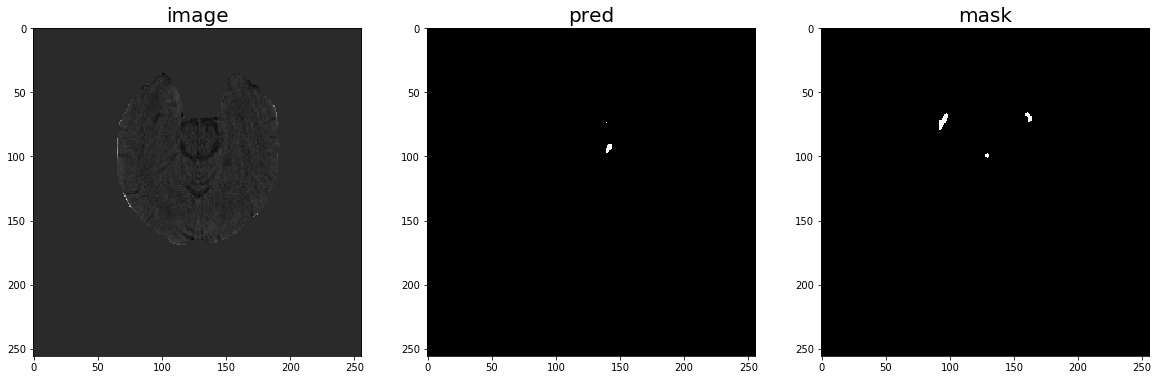

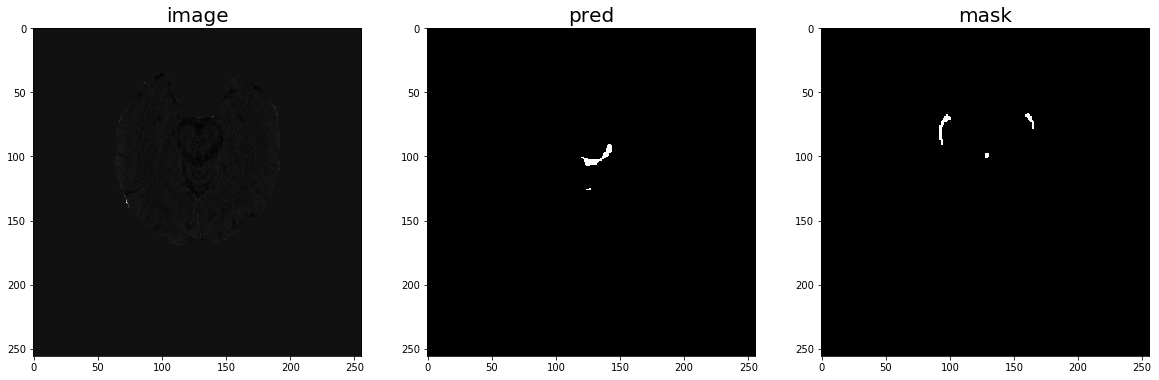

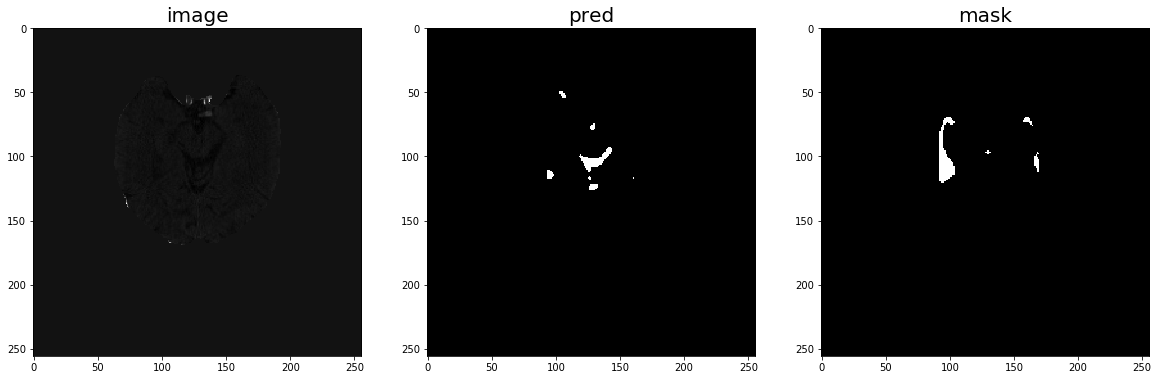

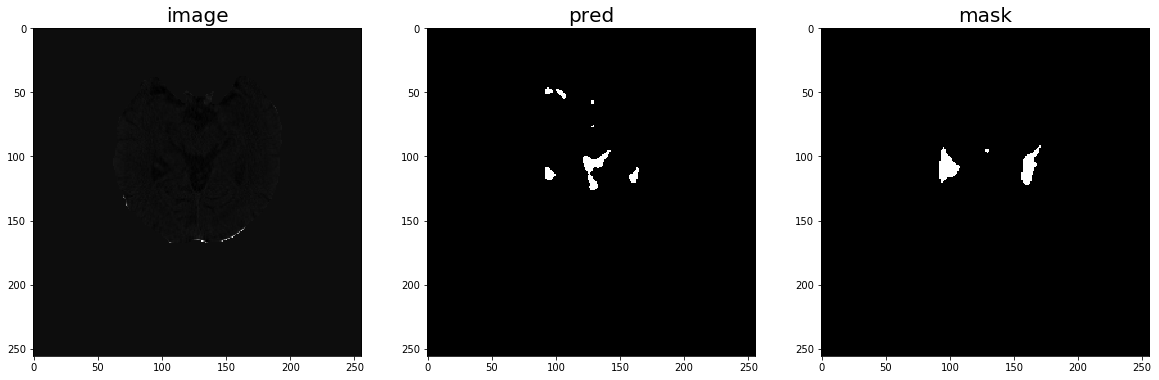

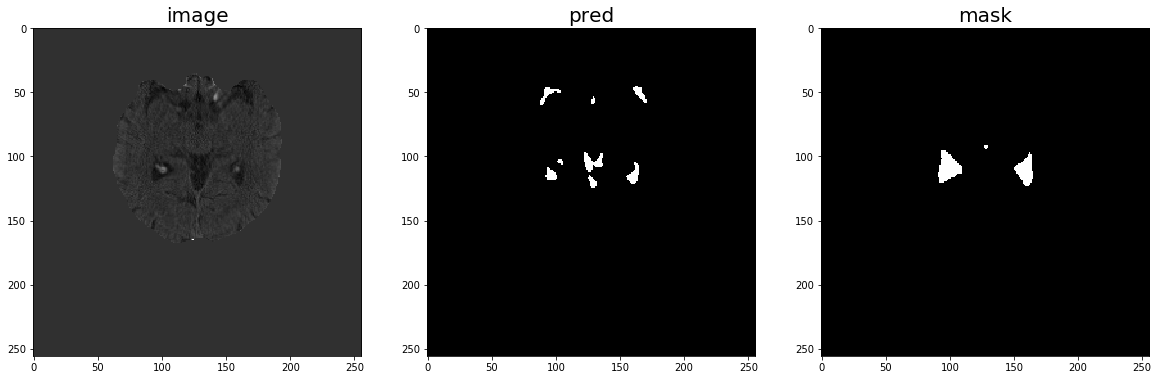

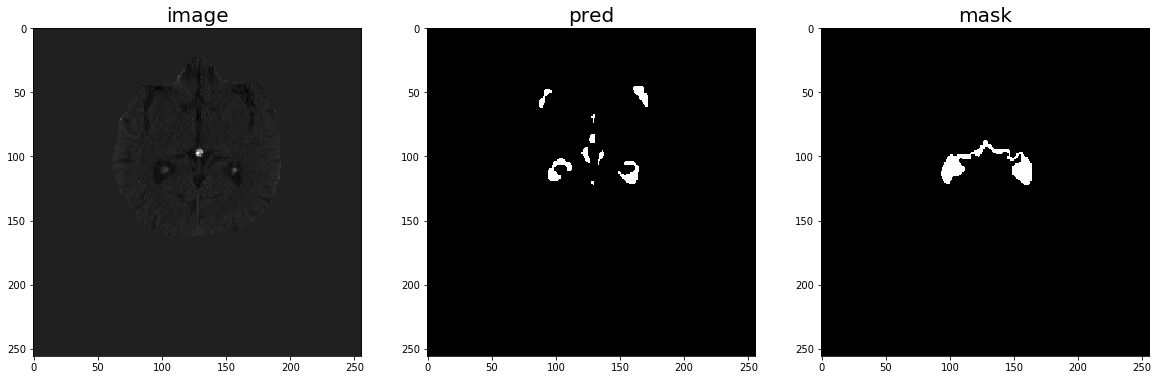

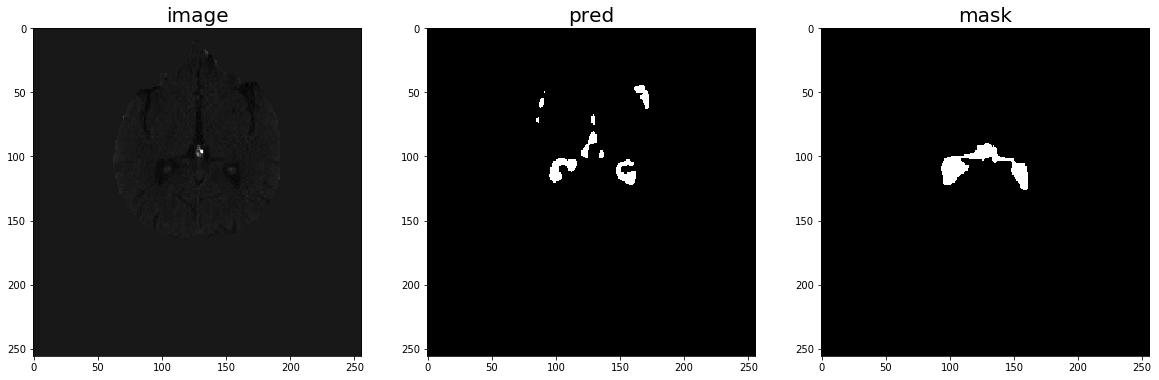

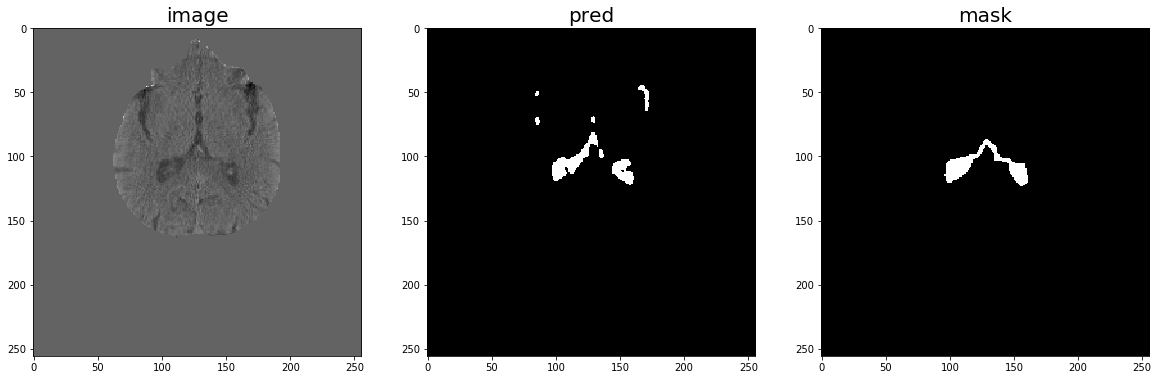

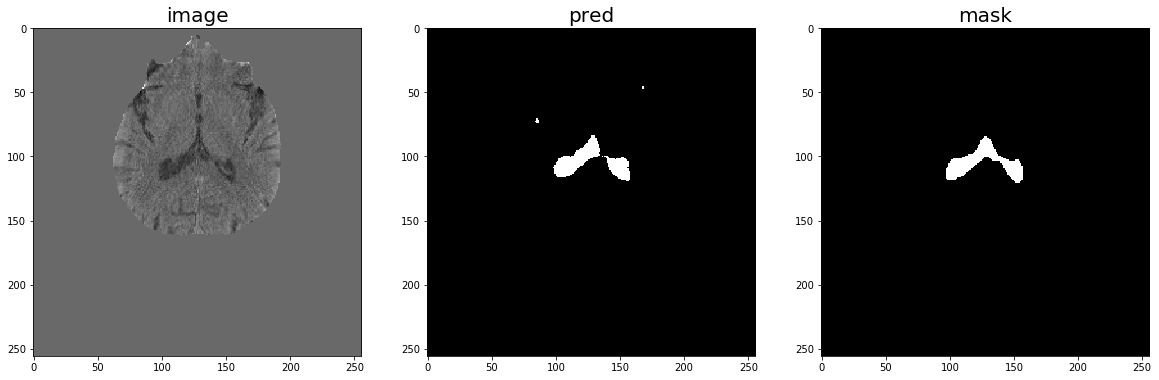

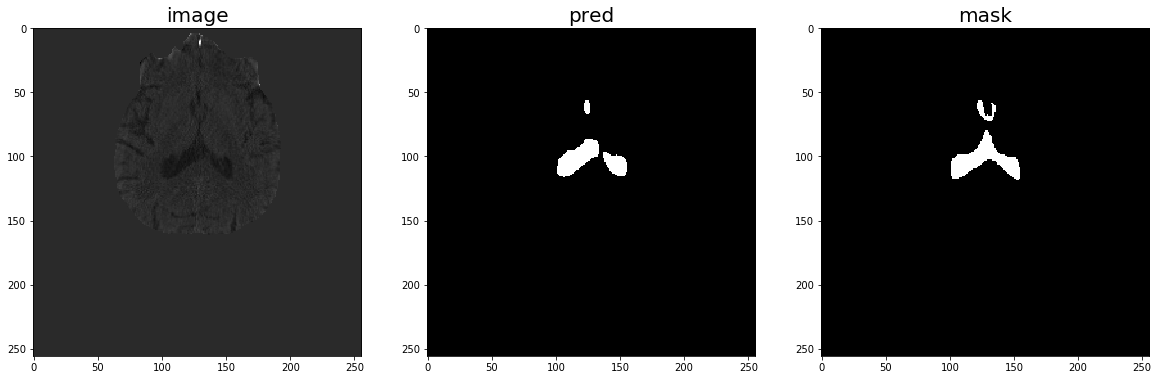

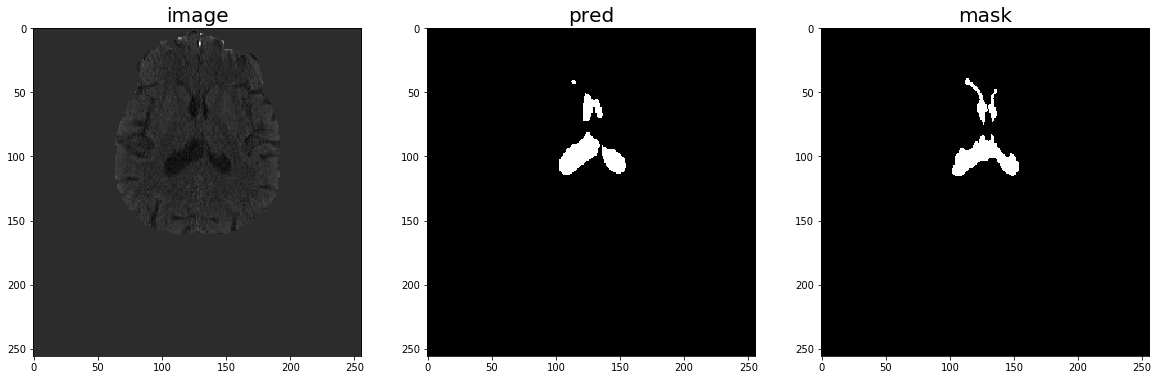

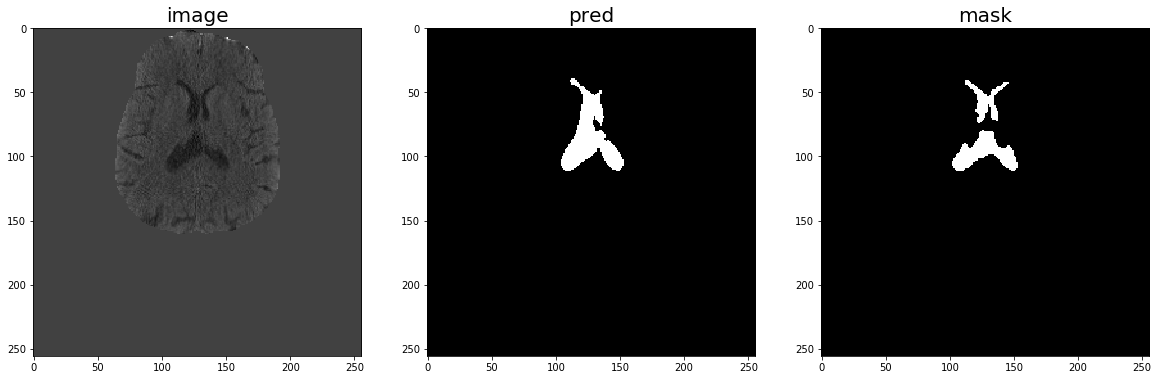

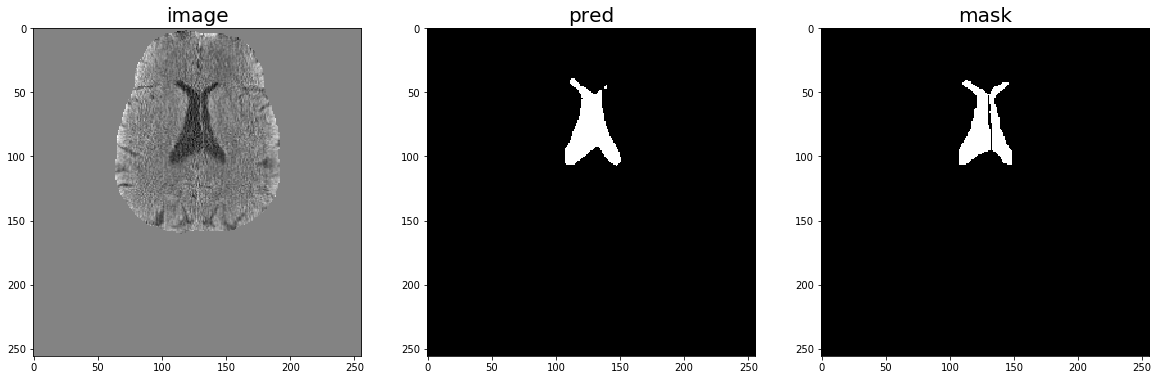

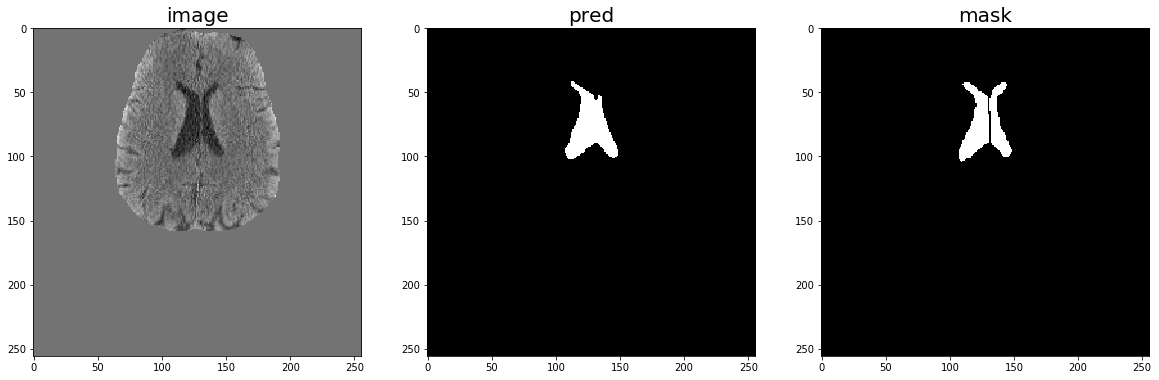

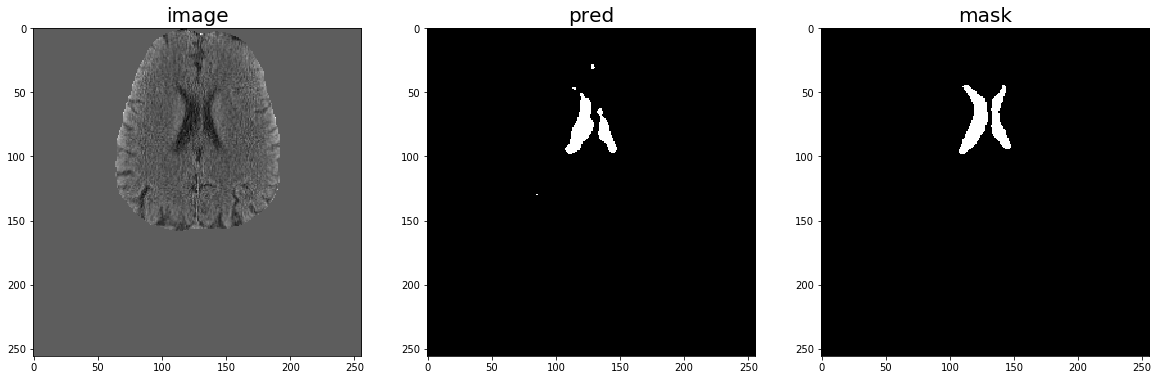

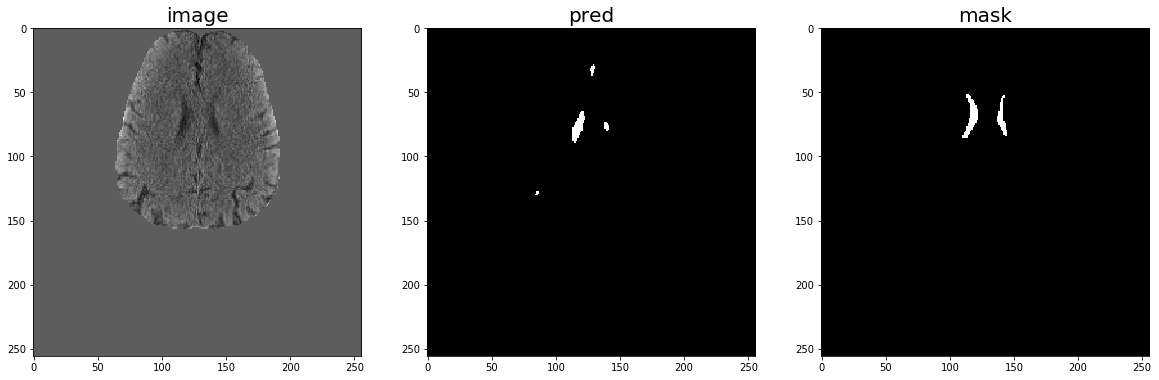

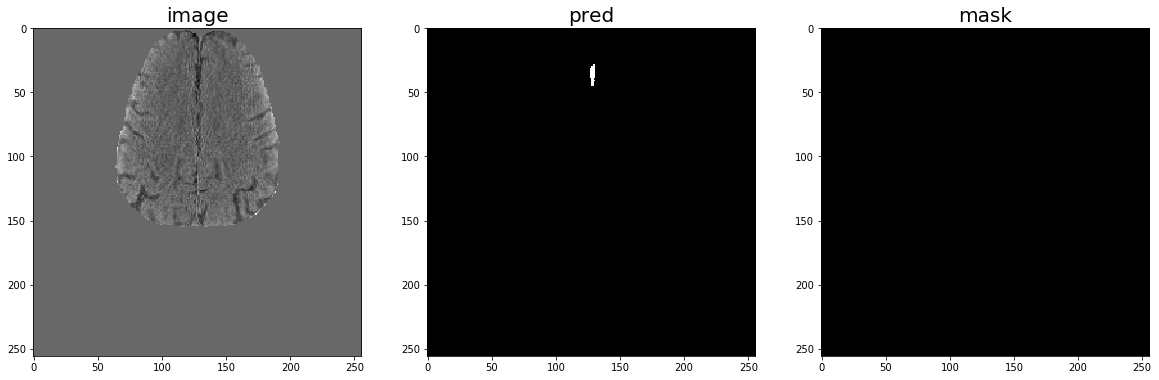

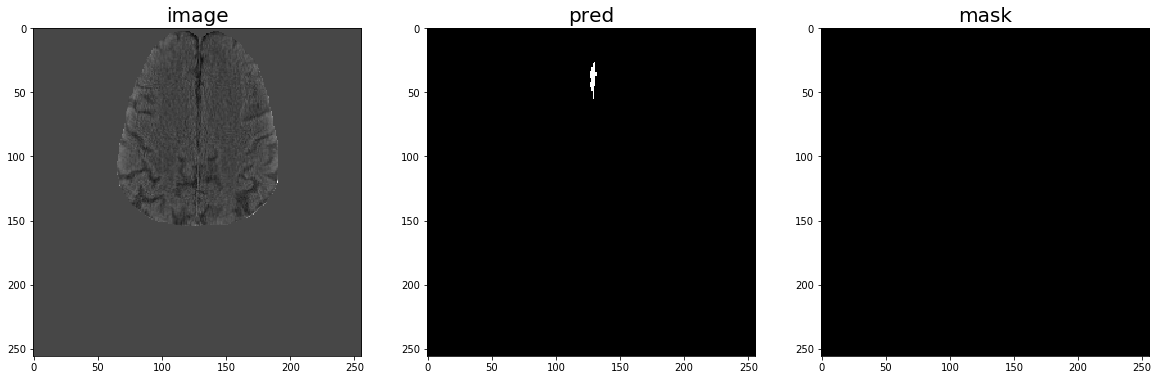

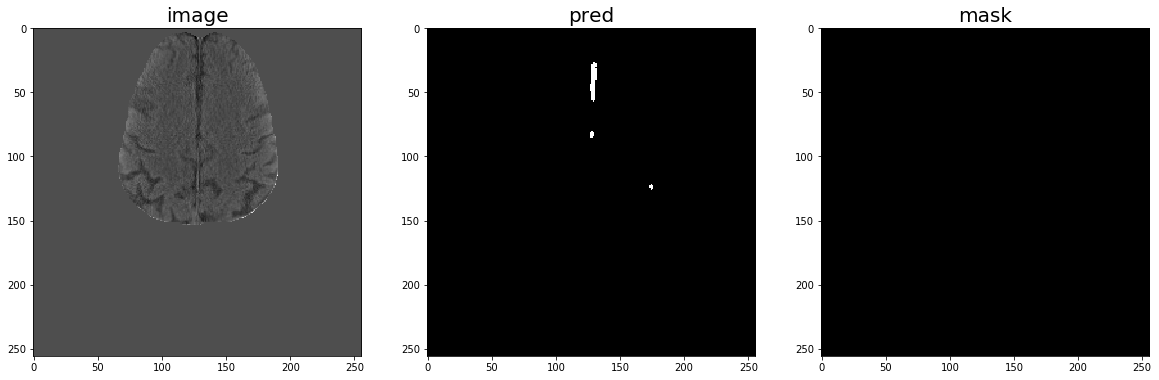

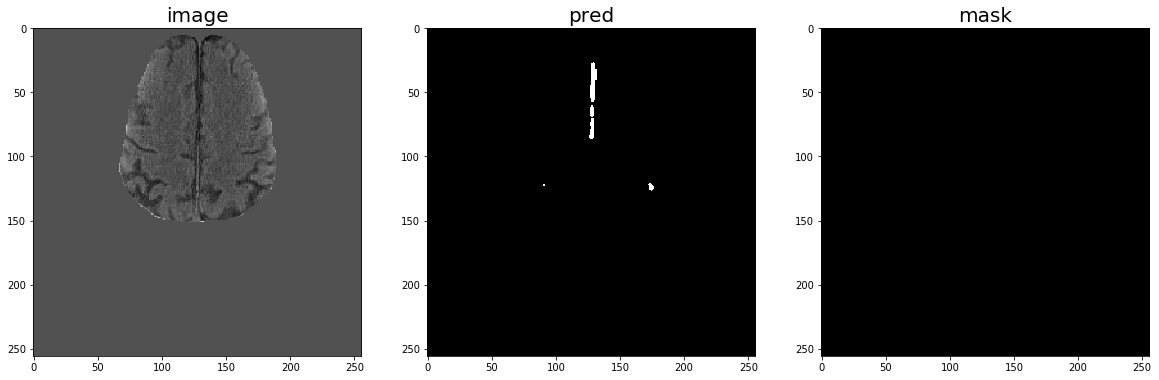

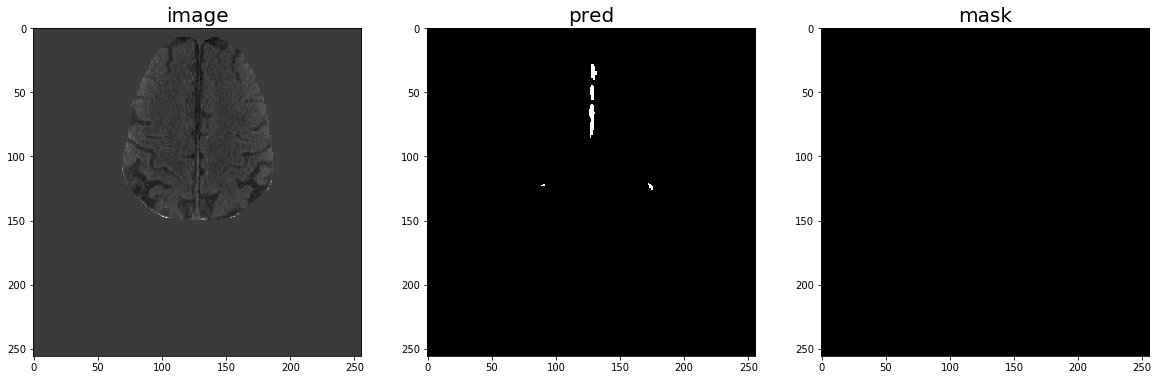

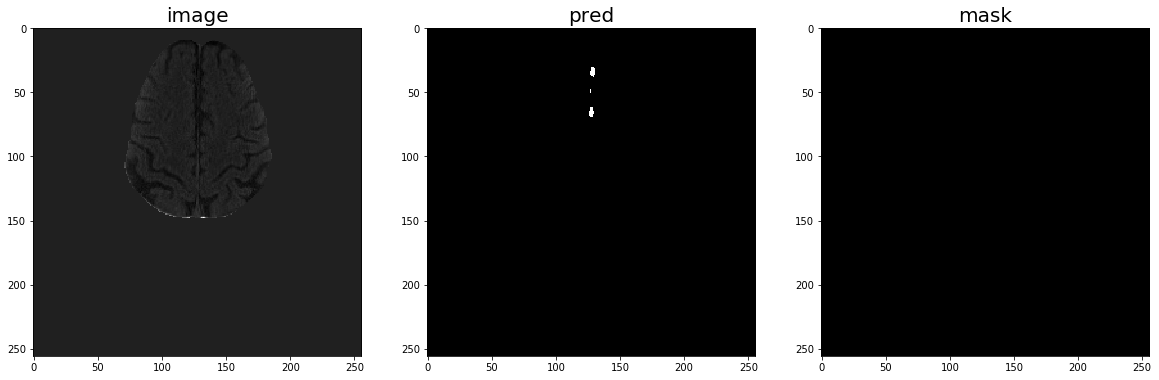

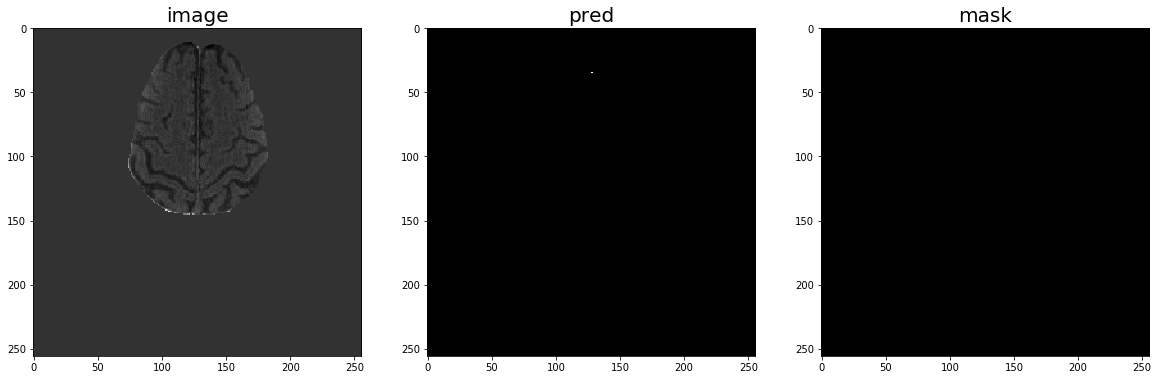

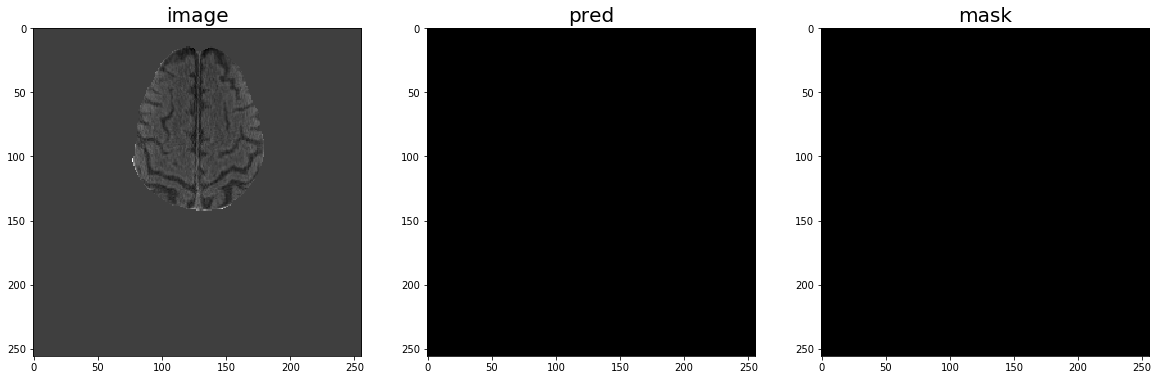

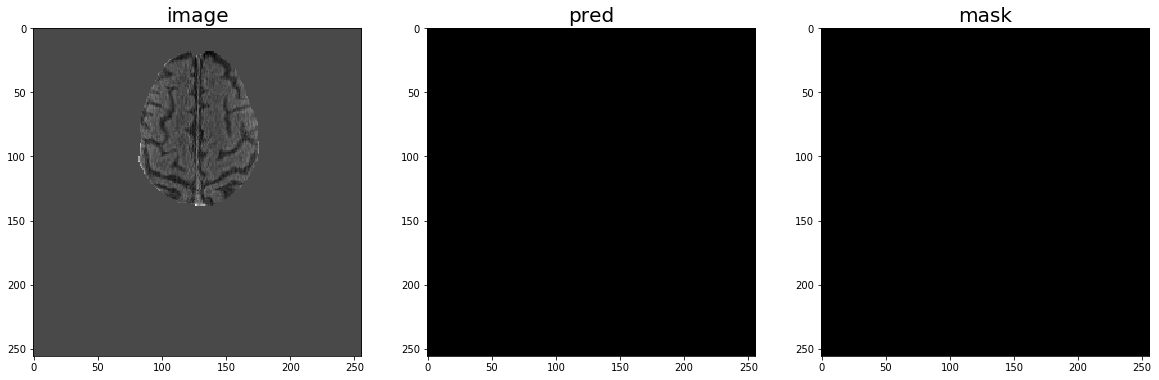

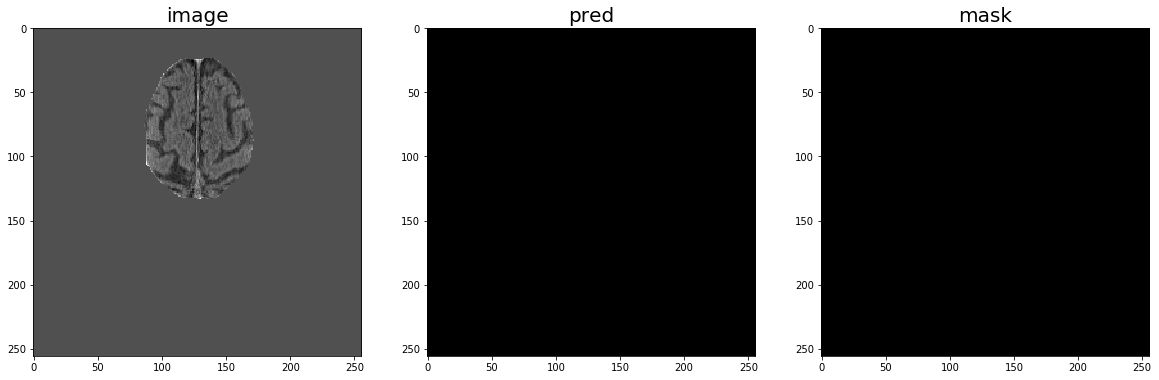

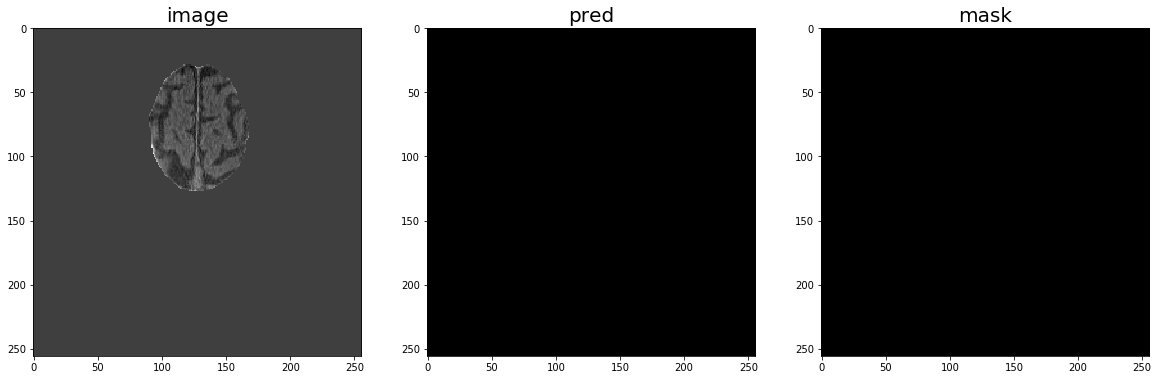

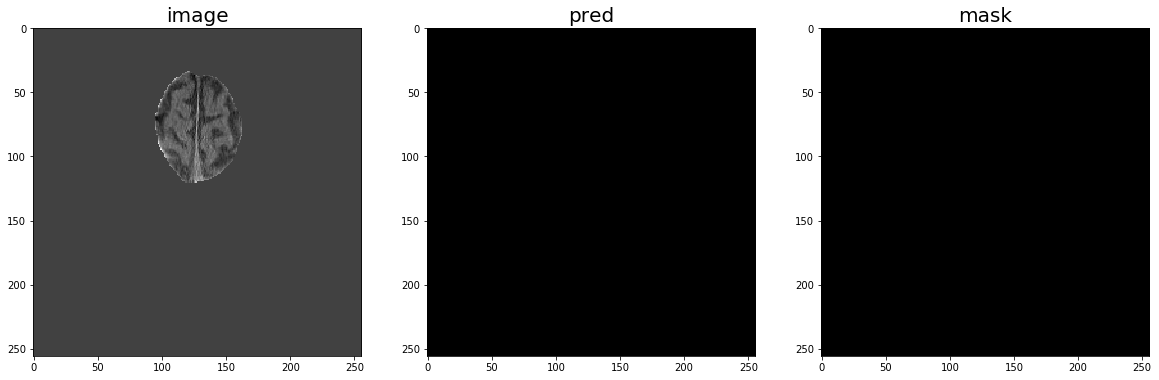

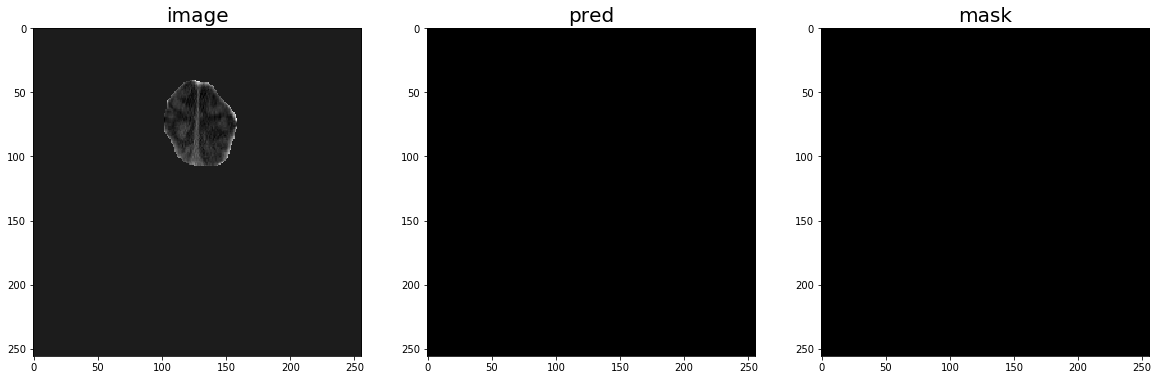

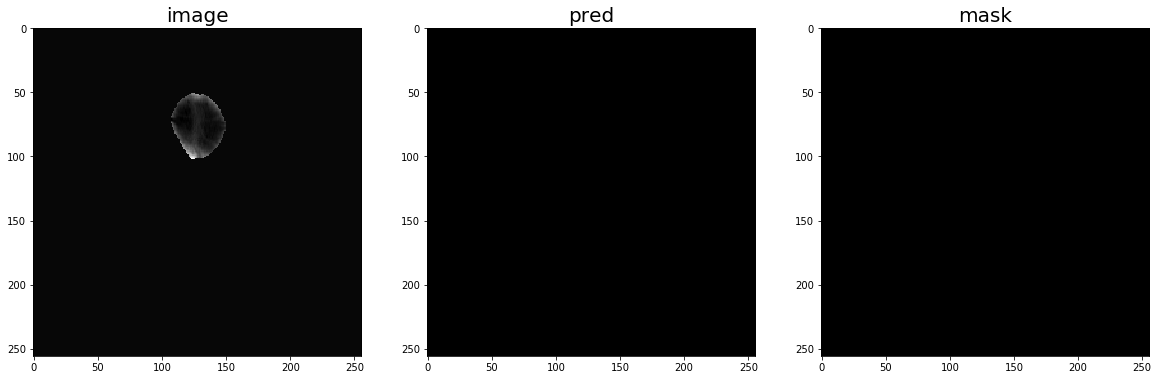

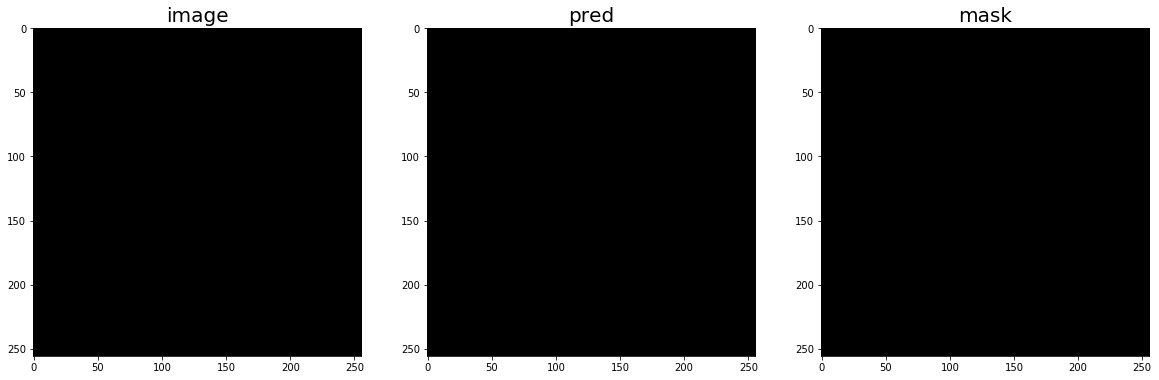

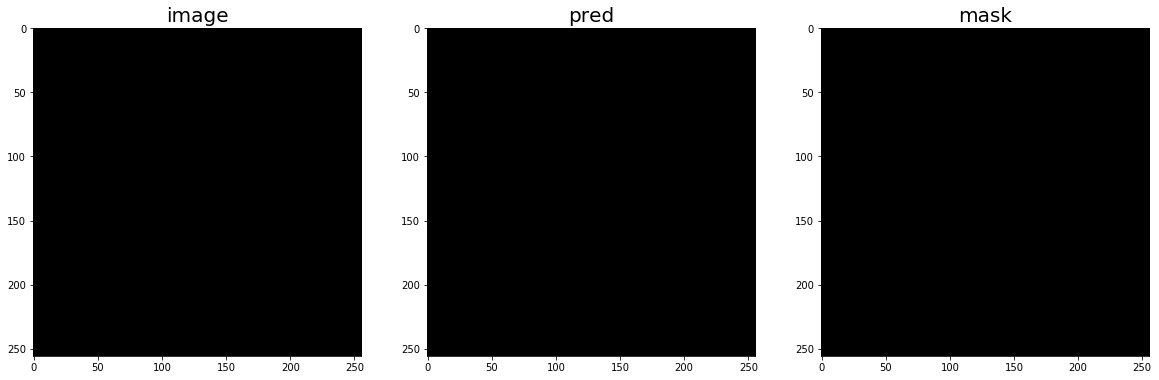

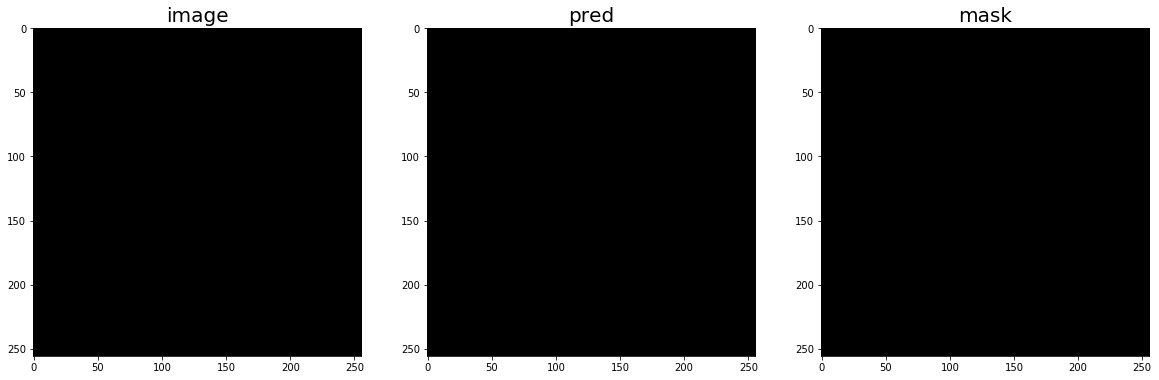

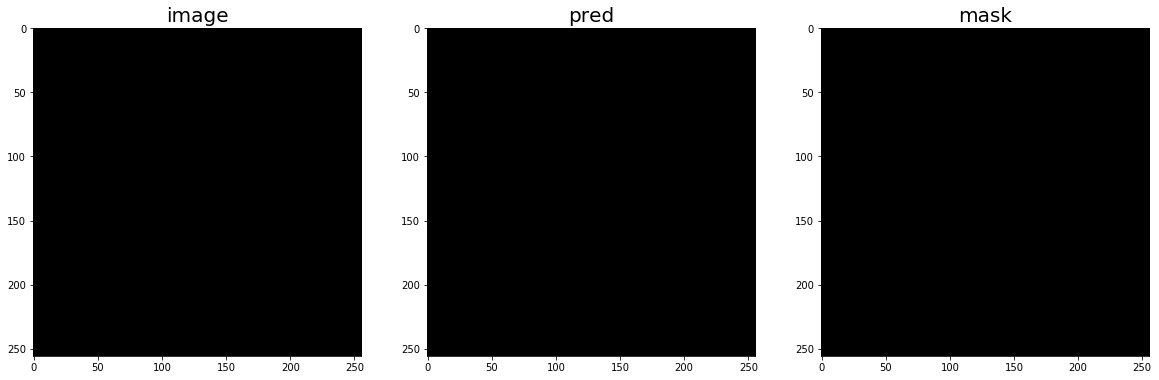

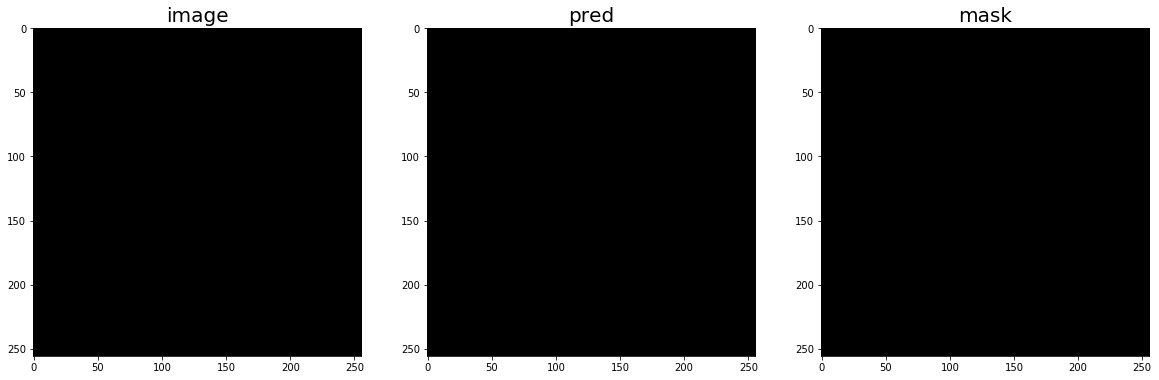

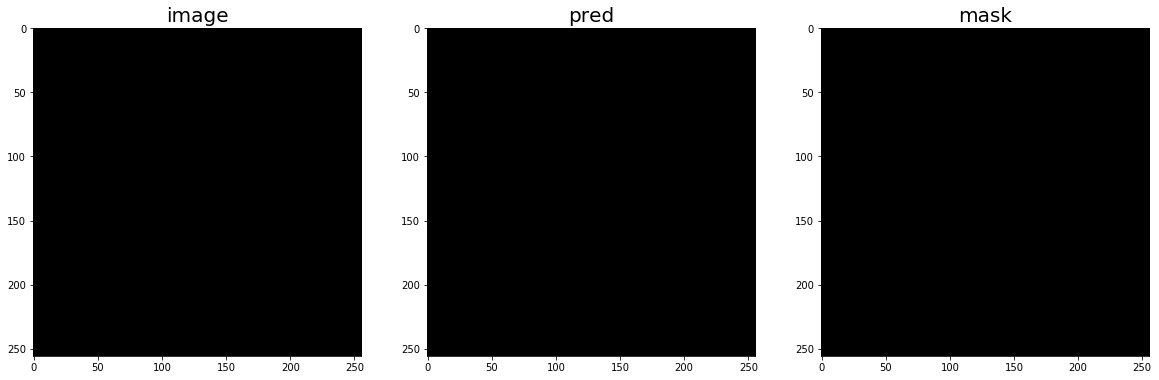

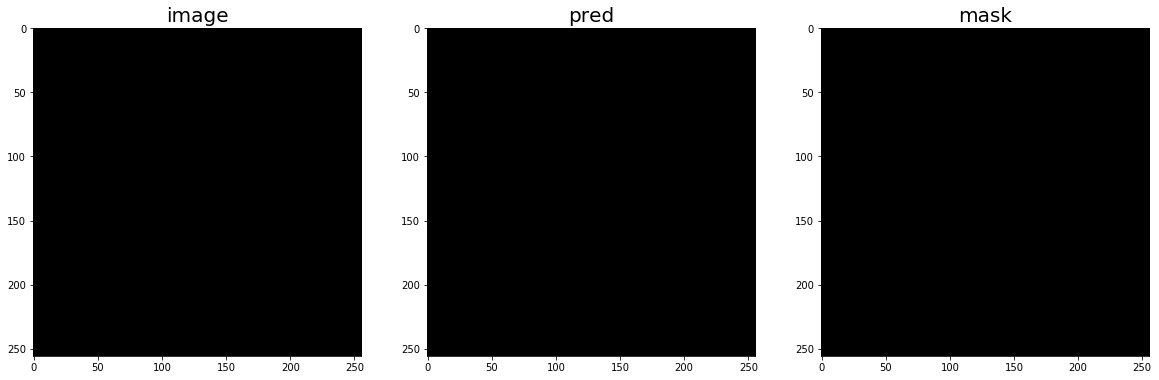

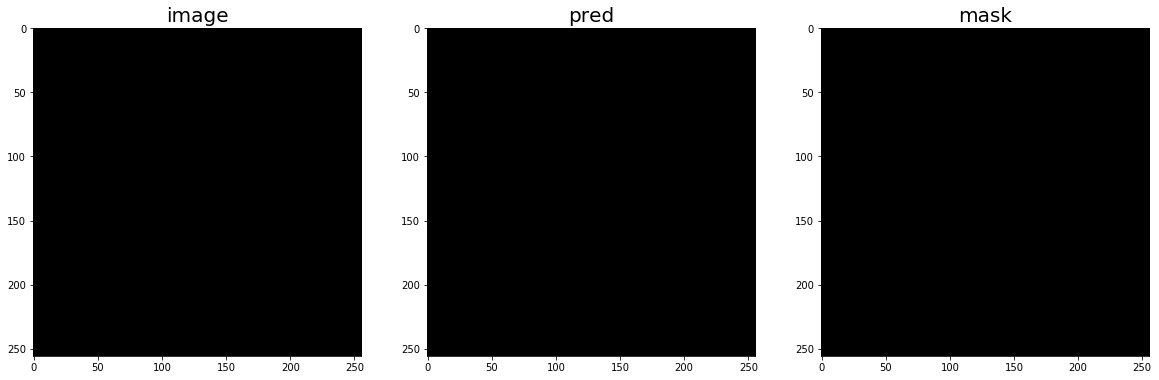

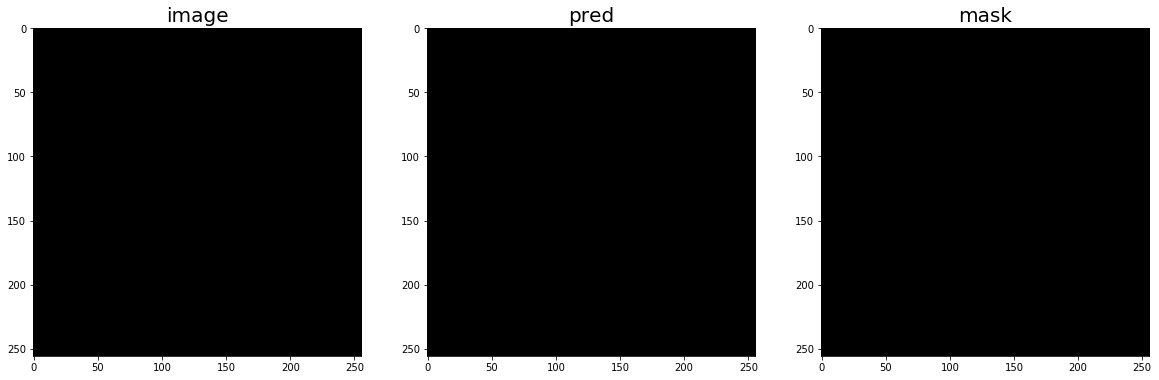

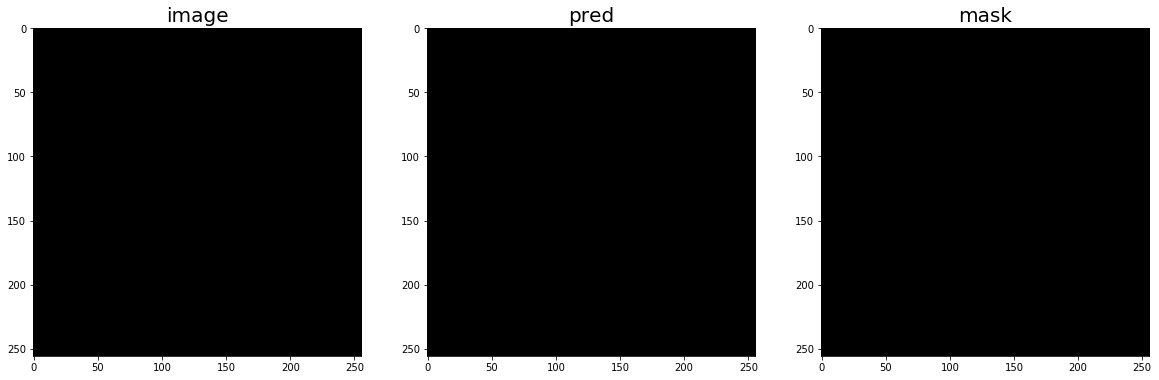

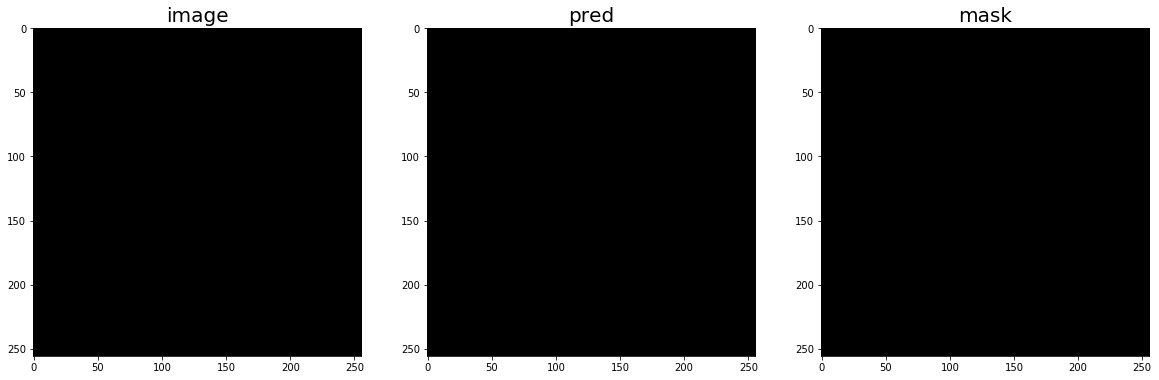

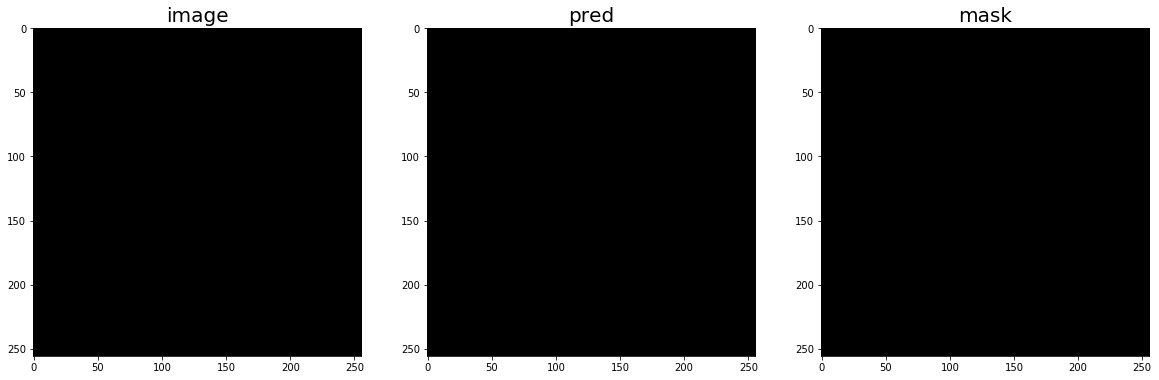

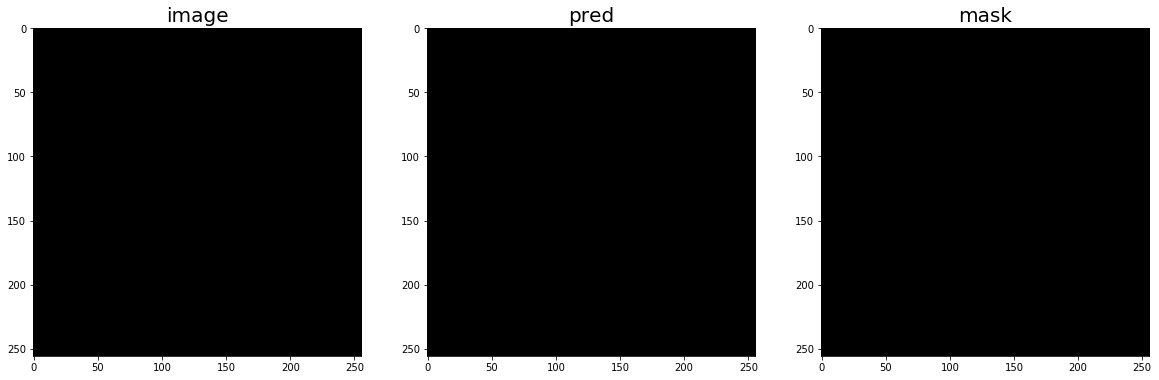

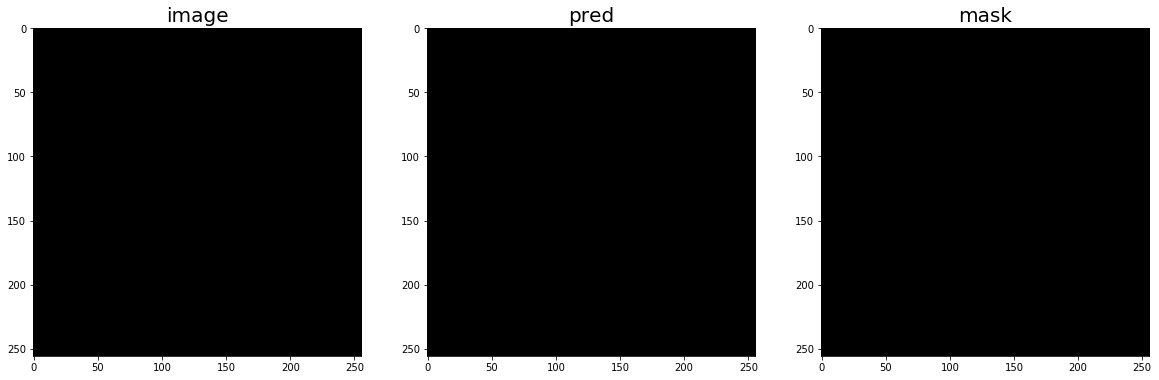

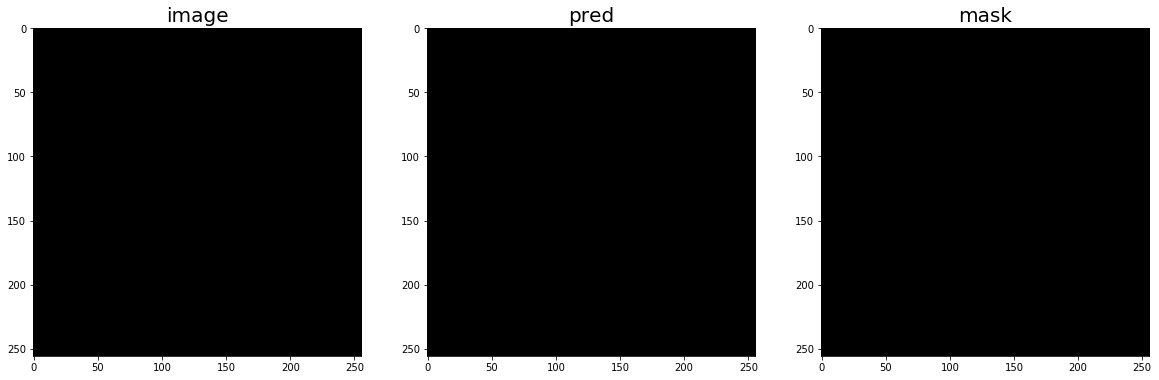

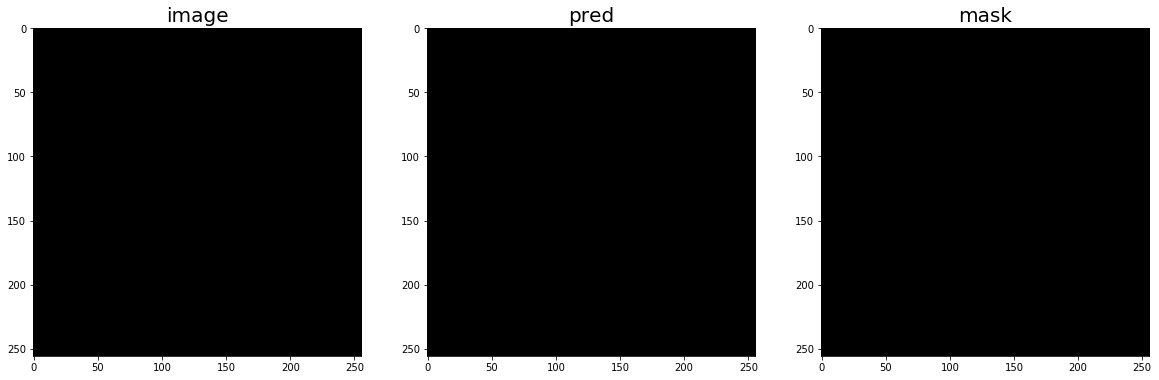

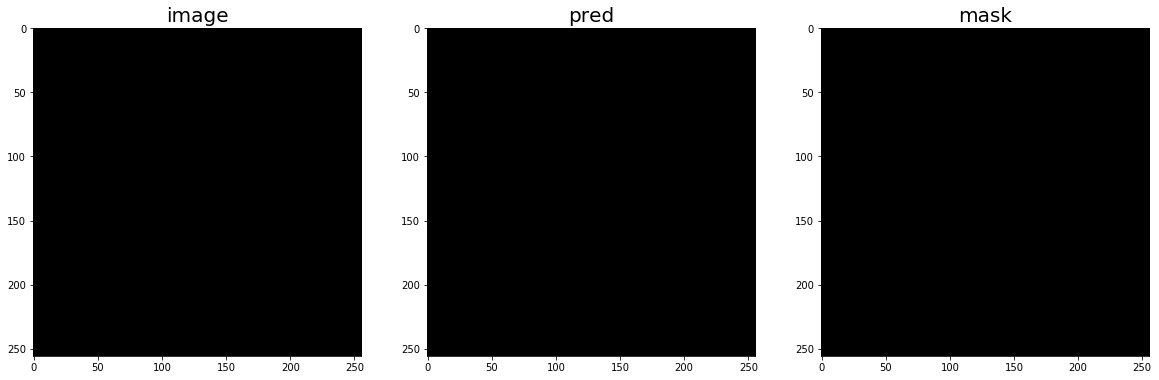

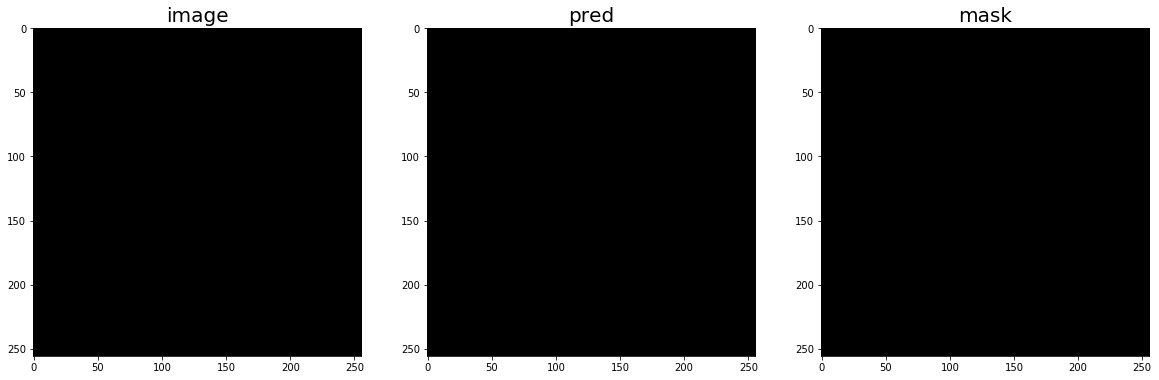

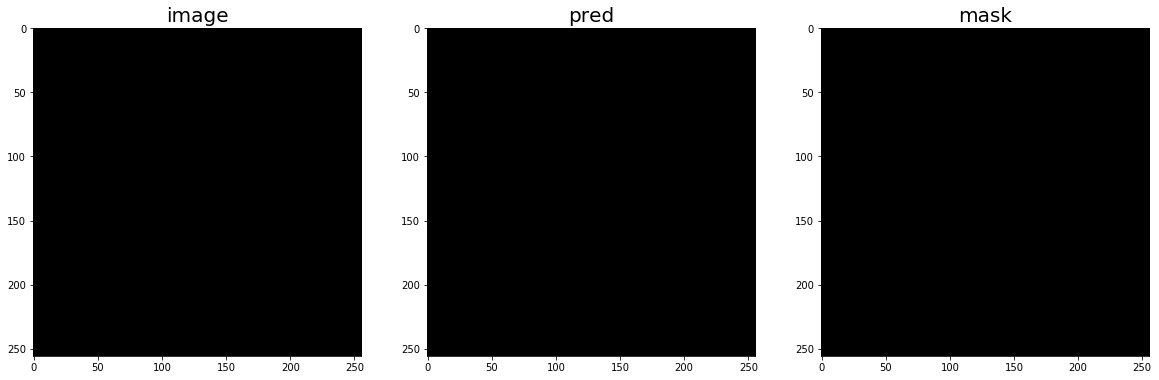

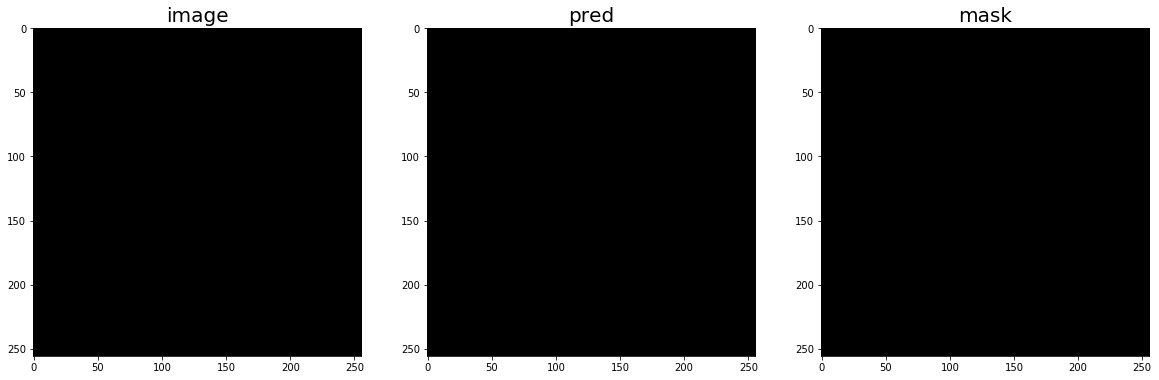

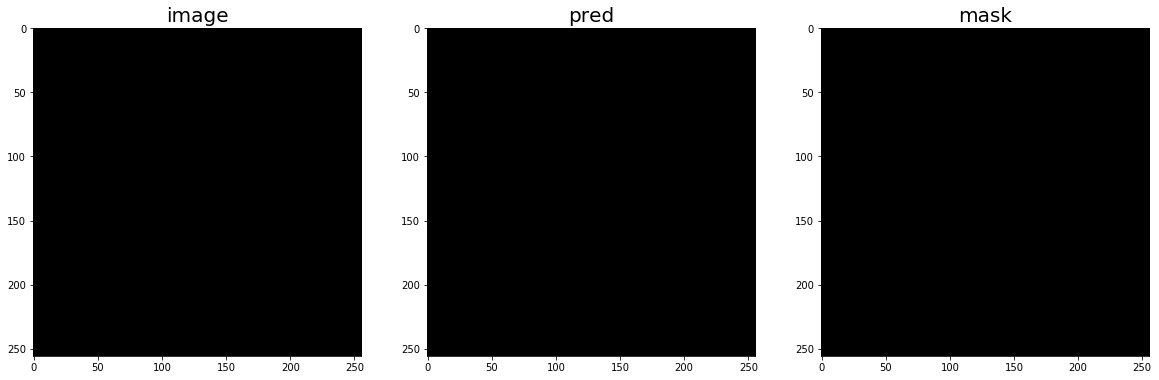

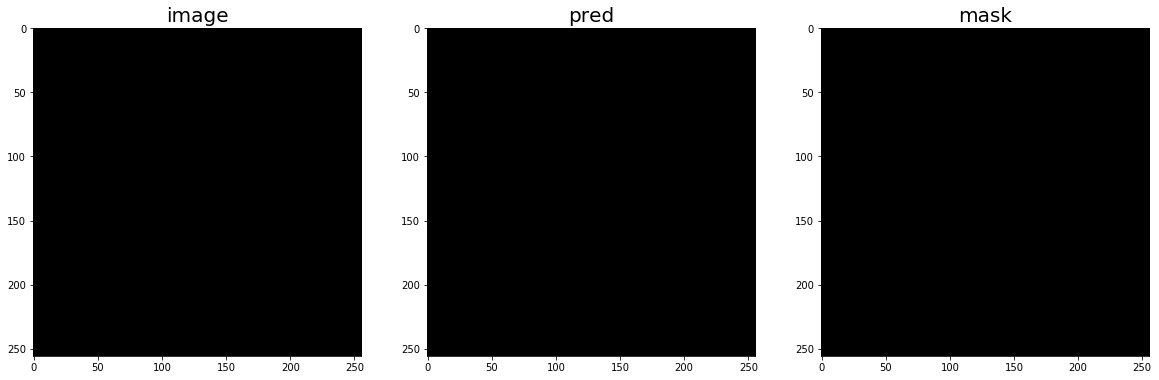

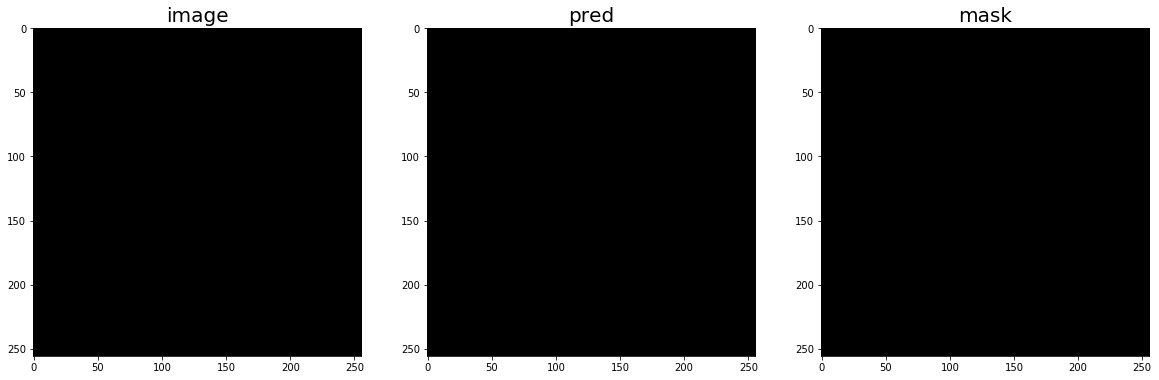

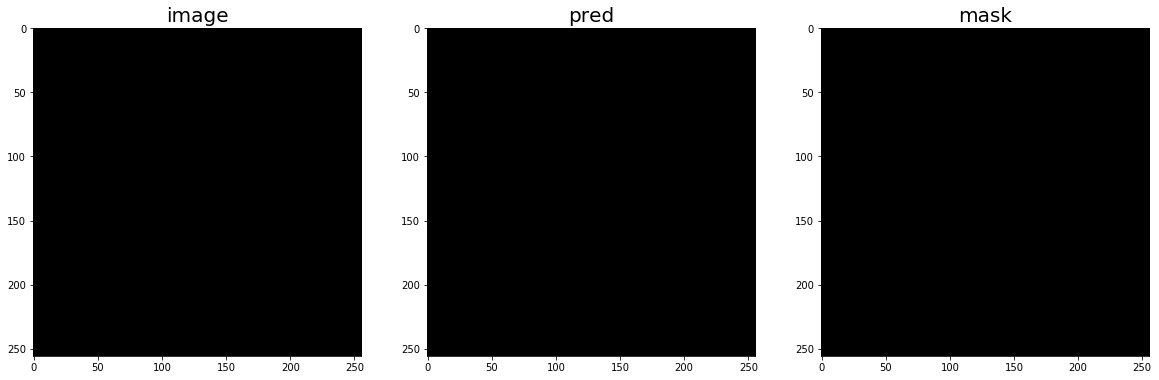

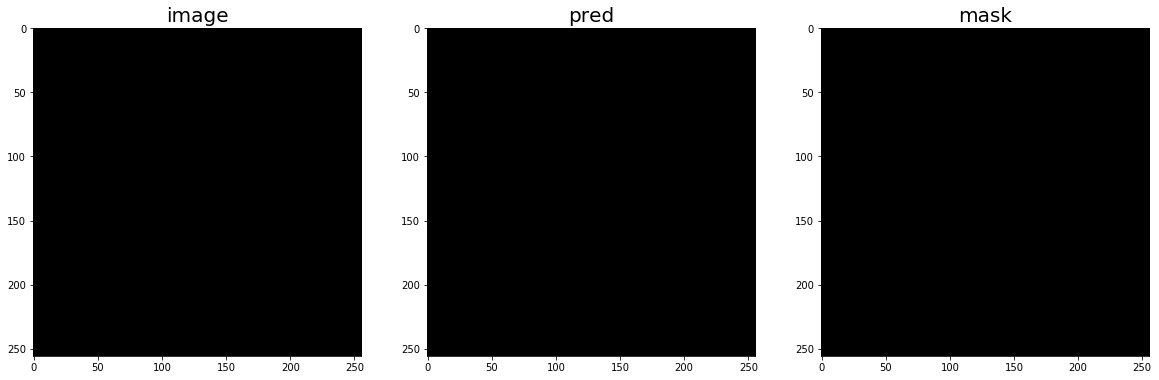

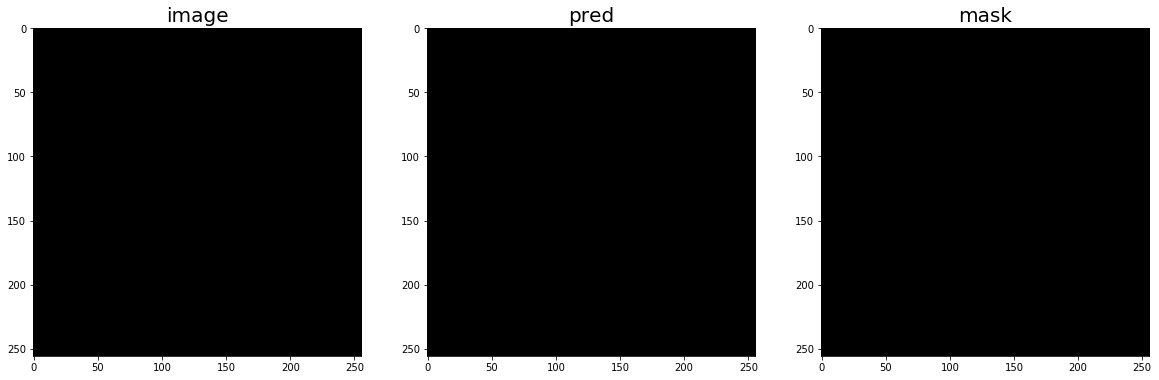

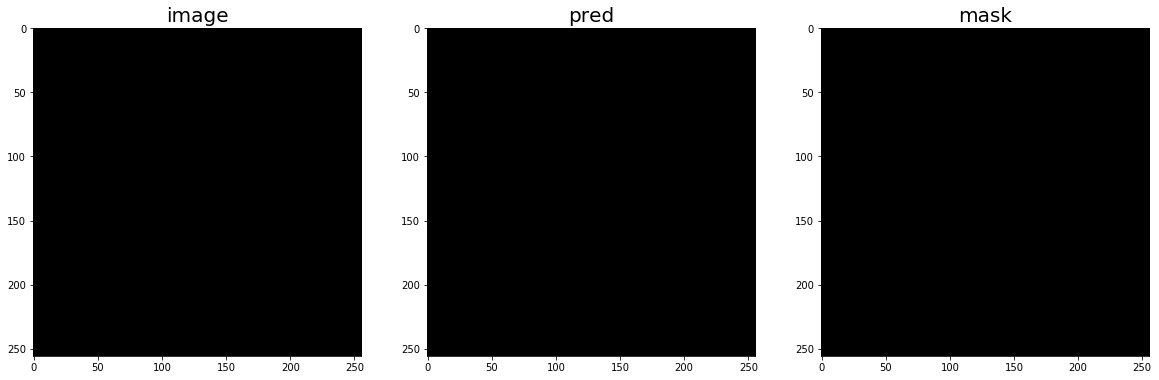

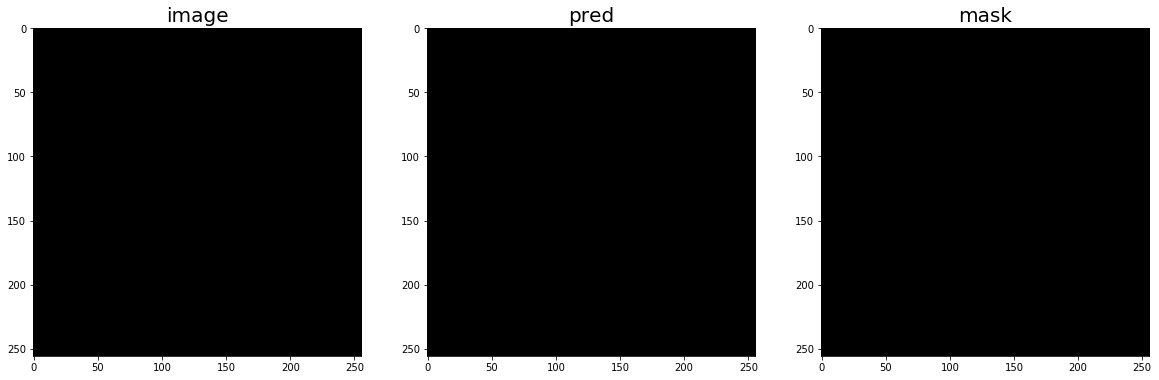

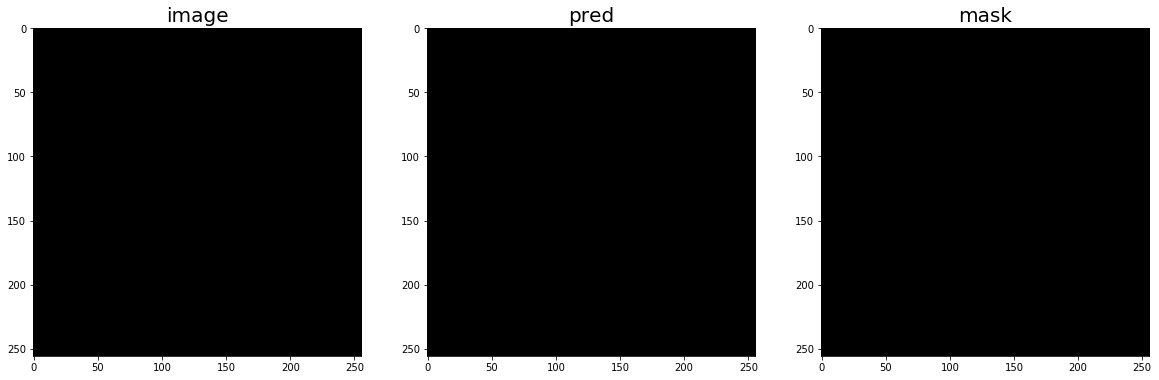

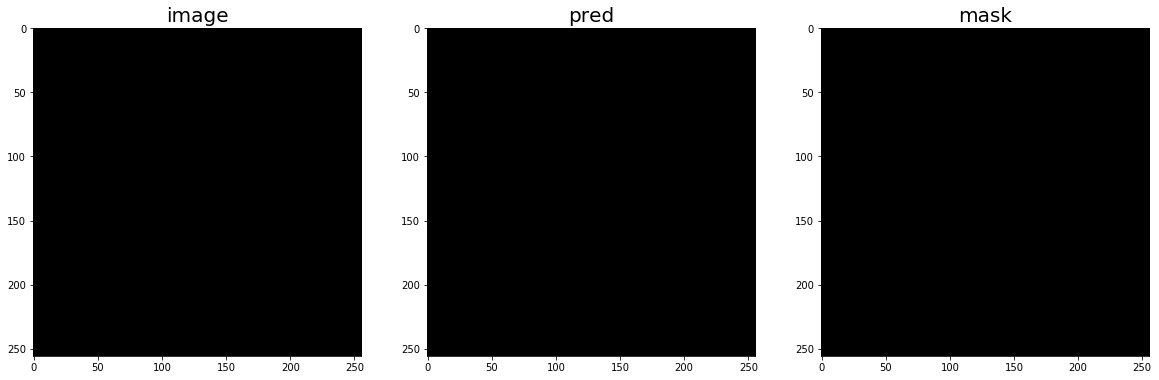

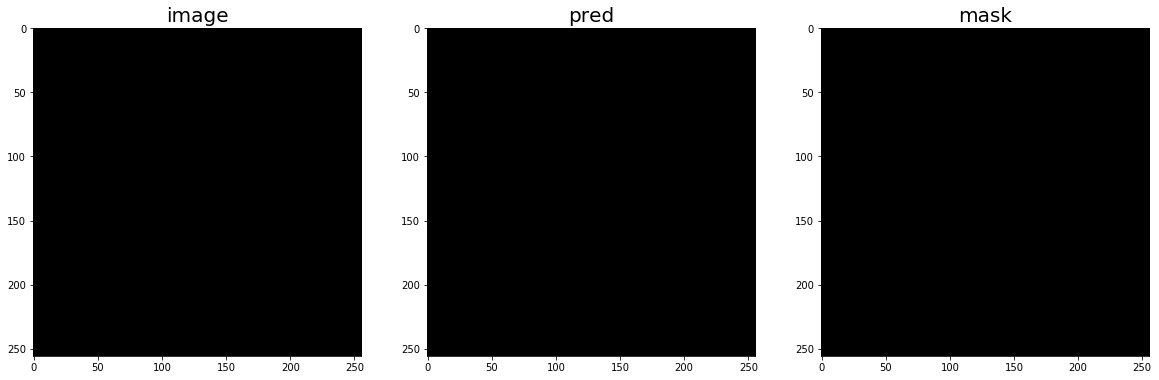

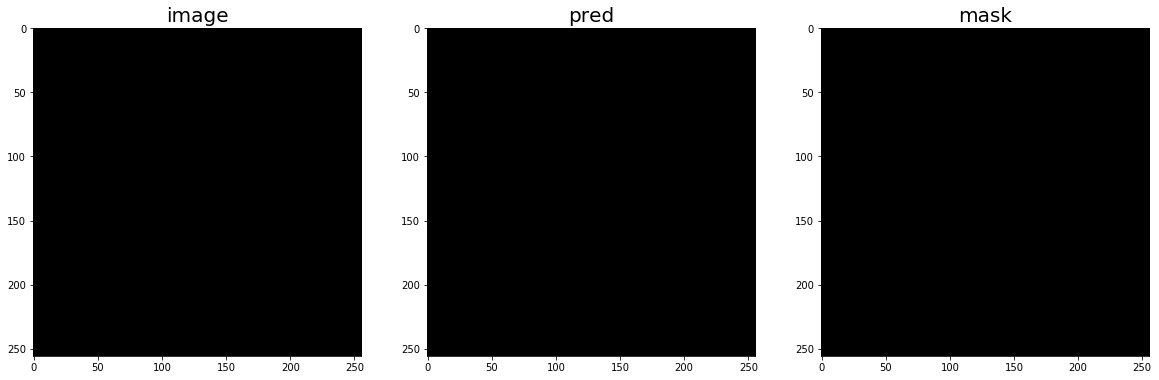

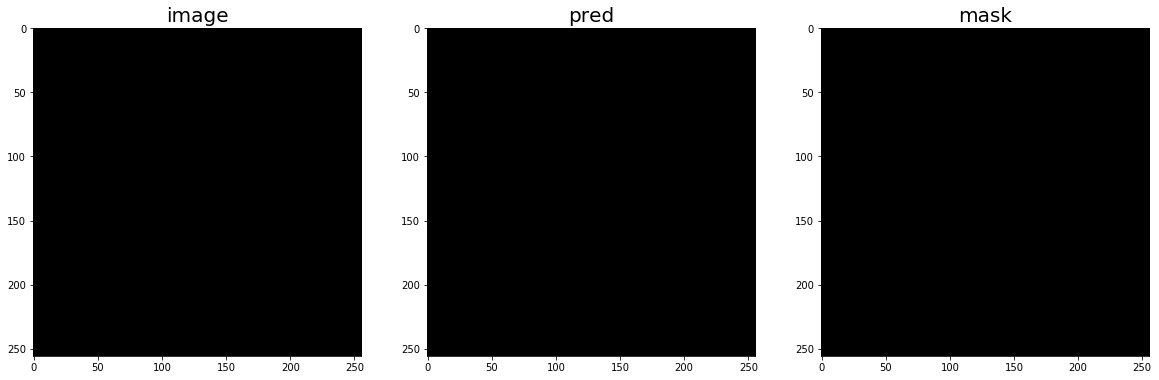

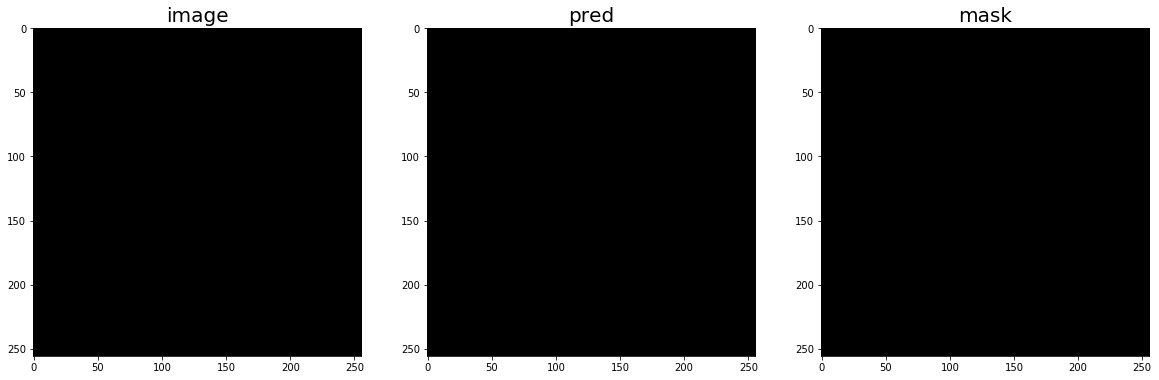

In [15]:
for i in range(image.shape[0]):
    plot_predictions(image[i], pred[i], mask[i])

In [16]:
eval_preds(preds, masks)

0.7068243520558051